## 1. Предобработка данных

In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from category_encoders.binary import BinaryEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold

In [4]:
file_path = 'data.tsv'
df_base = pd.read_csv(file_path, sep='\t')
df = df_base.copy()

In [5]:
df.head()

,Production_series,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Manufacture_country,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Wearing_mode,Curvature_radius,Refractive_range,Material
0,acuvue oasys with hydraclear plus,-1.00,1680,14.0,johnson&johnson,сша/ирландия,acuvue,прозрачные,38.0,147.0,6,две недели,дневной; допускается непрерывное ношение до 7 ...,8.4; 8.8,от -12.0d до +8.0d,силикон-гидрогель
1,air optix plus hydraglyde,-1.00,1380,14.2,alcon,малайзия/индонезия,airoptix,прозрачные,33.0,138.0,3,один месяц,дневной; допускается непрерывное ношение до 6 ...,8.6,от -12.0d до +8.0d,силикон-гидрогель
2,total30,-1.00,2120,NaN,alcon,германия,total,прозрачные,55.0,154.0,3,один месяц,дневной,8.4,от -12.0d до +6.0d,водоградиентный
3,precision1 for astigmatism,-1.25,2580,14.5,alcon,германия,precision,астигматические,87.0,90.0,30,один день,дневной,8.5,от -8.0d до +4.0d,силикон-гидрогель
4,total30 for astigmatism,-1.00,2580,NaN,alcon,германия,total,астигматические,55.0,123.0,3,один месяц,дневной,8.6,от -8.0d до +4.0d,водоградиентный


In [6]:
# Удалим дубликаты записей, если они присутствуют
df = df.drop_duplicates()

In [7]:
df.shape

(4064, 16)

#### Обработка целевого признака и подсчет дисбаланса классов

In [9]:
target_column = 'Package_quantity_pieces'

In [10]:
df[target_column].unique()

array([  6,   3,  30,  90,  12,  24, 180,   4,   2,   1])

In [12]:
df[target_column] = np.where(df[target_column].isin([1, 2, 4, 3, 6]), 0, 1)

In [13]:
df[target_column].value_counts()

Package_quantity_pieces
0    2032
1    2032
Name: count, dtype: int64

In [14]:
# посчитаем дисбаланс классов
total = df.shape[0]
class_0, class_1 = df[target_column].value_counts()
print(f'Класс 0 составляет {round(class_0 / total, 4)*100}%,\n класс 1 составляет {round(class_1 / total, 4)*100}%')

Класс 0 составляет 50.0%,
 класс 1 составляет 50.0%


In [15]:
df.insert(0, 'Package_quantity_pieces', df.pop(target_column))

In [17]:
df.head()

,Package_quantity_pieces,Production_series,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Manufacture_country,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Wearing_mode,Curvature_radius,Refractive_range,Material
0,0,acuvue oasys with hydraclear plus,-1.00,1680,14.0,johnson&johnson,сша/ирландия,acuvue,прозрачные,38.0,147.0,две недели,дневной; допускается непрерывное ношение до 7 ...,8.4; 8.8,от -12.0d до +8.0d,силикон-гидрогель
1,0,air optix plus hydraglyde,-1.00,1380,14.2,alcon,малайзия/индонезия,airoptix,прозрачные,33.0,138.0,один месяц,дневной; допускается непрерывное ношение до 6 ...,8.6,от -12.0d до +8.0d,силикон-гидрогель
2,0,total30,-1.00,2120,NaN,alcon,германия,total,прозрачные,55.0,154.0,один месяц,дневной,8.4,от -12.0d до +6.0d,водоградиентный
3,1,precision1 for astigmatism,-1.25,2580,14.5,alcon,германия,precision,астигматические,87.0,90.0,один день,дневной,8.5,от -8.0d до +4.0d,силикон-гидрогель
4,0,total30 for astigmatism,-1.00,2580,NaN,alcon,германия,total,астигматические,55.0,123.0,один месяц,дневной,8.6,от -8.0d до +4.0d,водоградиентный


##### Вывод. Дисбаланс классов отсутствует.

#### Обработка пропусков

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4064 entries, 0 to 51380
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Package_quantity_pieces   4064 non-null   int64  
 1   Production_series         4064 non-null   object 
 2   Optical_power             4063 non-null   float64
 3   Price_rub                 4064 non-null   int64  
 4   MKL_Diameter_mm           3682 non-null   float64
 5   Manufacturer              4064 non-null   object 
 6   Manufacture_country       4064 non-null   object 
 7   Brand                     4064 non-null   object 
 8   Lens_type                 4064 non-null   object 
 9   Moisture_content_%        4064 non-null   float64
 10  Oxygen_transmission_Dk/t  4064 non-null   float64
 11  Replacement_period        4064 non-null   object 
 12  Wearing_mode              4064 non-null   object 
 13  Curvature_radius          4064 non-null   object 
 14  Refractive_r

In [21]:
df.describe()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t
count,4064.000000,4063.000000,4064.000000,3682.000000,4064.000000,4064.000000
mean,0.500000,-1.850172,2894.542323,14.190521,52.115896,97.389673
std,0.500062,5.037167,1731.180177,0.156068,14.342638,51.421193
min,0.000000,-20.000000,910.000000,13.800000,24.000000,14.200000
25%,0.000000,-5.250000,1950.000000,14.100000,38.000000,41.500000
50%,0.500000,-2.000000,2430.000000,14.200000,55.000000,108.000000
75%,1.000000,2.000000,3140.000000,14.200000,58.000000,143.250000
max,1.000000,20.000000,12360.000000,14.500000,87.000000,175.000000


In [22]:
df.isnull().sum()

Package_quantity_pieces       0
Production_series             0
Optical_power                 1
Price_rub                     0
MKL_Diameter_mm             382
Manufacturer                  0
Manufacture_country           0
Brand                         0
Lens_type                     0
Moisture_content_%            0
Oxygen_transmission_Dk/t      0
Replacement_period            0
Wearing_mode                  0
Curvature_radius              0
Refractive_range            267
Material                      0
dtype: int64

In [23]:
for col in df.columns:
    print(f'{col}: {df[col].isna().sum() / df.shape[0] * 100:.2f}%')

Package_quantity_pieces: 0.00%
Production_series: 0.00%
Optical_power: 0.02%
Price_rub: 0.00%
MKL_Diameter_mm: 9.40%
Manufacturer: 0.00%
Manufacture_country: 0.00%
Brand: 0.00%
Lens_type: 0.00%
Moisture_content_%: 0.00%
Oxygen_transmission_Dk/t: 0.00%
Replacement_period: 0.00%
Wearing_mode: 0.00%
Curvature_radius: 0.00%
Refractive_range: 6.57%
Material: 0.00%


In [24]:
df.shape

(4064, 16)

##### Количественные признаки

In [26]:
df['Optical_power'].value_counts()

Optical_power
-1.5     83
-4.5     83
-3.5     81
-5.5     81
-3.0     81
         ..
 10.5     1
 18.0     1
 17.0     1
 20.0     1
-17.5     1
Name: count, Length: 111, dtype: int64

In [27]:
df.dropna(subset=['Optical_power'], axis=0, inplace=True)
df.shape

(4063, 16)

##### Качественные признаки

In [37]:
df['MKL_Diameter_mm'].value_counts()

MKL_Diameter_mm
14.2    1720
14.0     815
14.5     493
14.1     317
14.3     293
13.8      43
Name: count, dtype: int64

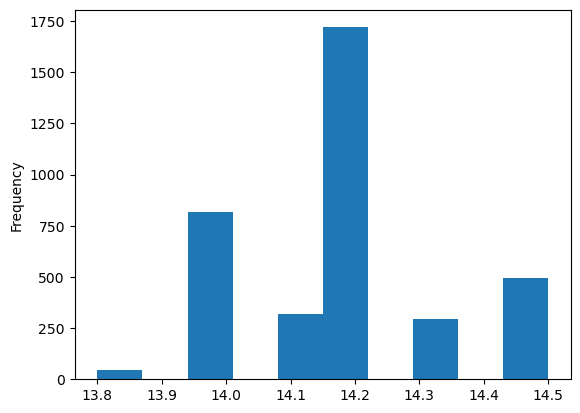

In [38]:
df['MKL_Diameter_mm'].plot(kind='hist', bins=10);

In [39]:
df['MKL_Diameter_mm'].mode()

0    14.2
Name: MKL_Diameter_mm, dtype: float64

In [40]:
df['MKL_Diameter_mm'].fillna(df['MKL_Diameter_mm'].mode().iloc[0], inplace=True)

##### Удаление ненужных признаков

In [42]:
df.drop(['Refractive_range', 'Wearing_mode', 'Production_series', 'Curvature_radius', 'Manufacture_country'], axis=1, inplace=True)
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Material
0,0,-1.00,1680,14.0,johnson&johnson,acuvue,прозрачные,38.0,147.0,две недели,силикон-гидрогель
1,0,-1.00,1380,14.2,alcon,airoptix,прозрачные,33.0,138.0,один месяц,силикон-гидрогель
2,0,-1.00,2120,14.2,alcon,total,прозрачные,55.0,154.0,один месяц,водоградиентный
3,1,-1.25,2580,14.5,alcon,precision,астигматические,87.0,90.0,один день,силикон-гидрогель
4,0,-1.00,2580,14.2,alcon,total,астигматические,55.0,123.0,один месяц,водоградиентный


In [43]:
df.isnull().sum()

Package_quantity_pieces     0
Optical_power               0
Price_rub                   0
MKL_Diameter_mm             0
Manufacturer                0
Brand                       0
Lens_type                   0
Moisture_content_%          0
Oxygen_transmission_Dk/t    0
Replacement_period          0
Material                    0
dtype: int64

In [44]:
df.shape

(4063, 11)

In [45]:
df.columns

Index(['Package_quantity_pieces', 'Optical_power', 'Price_rub',
       'MKL_Diameter_mm', 'Manufacturer', 'Brand', 'Lens_type',
       'Moisture_content_%', 'Oxygen_transmission_Dk/t', 'Replacement_period',
       'Material'],
      dtype='object')

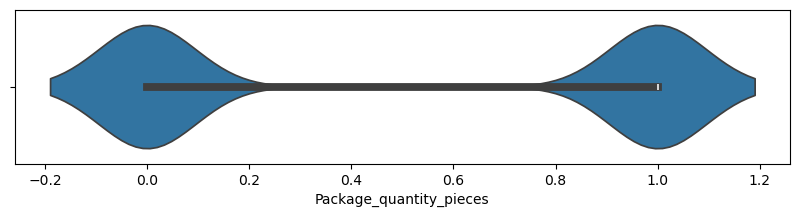

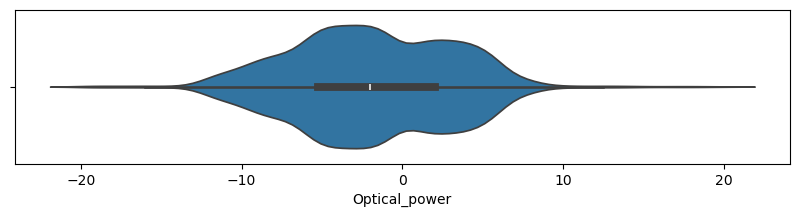

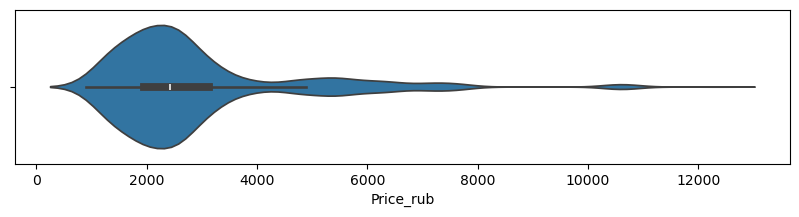

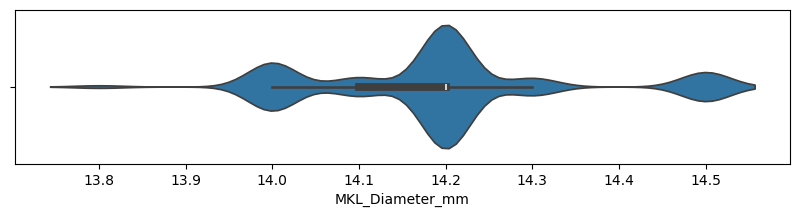

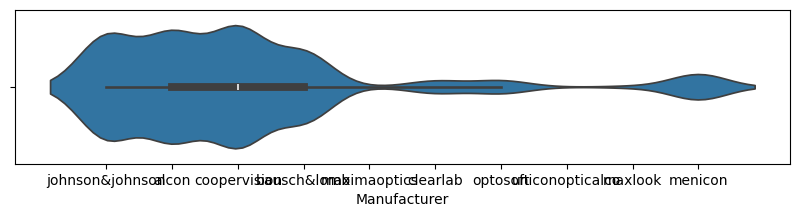

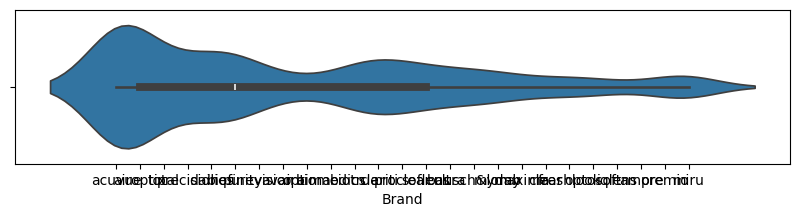

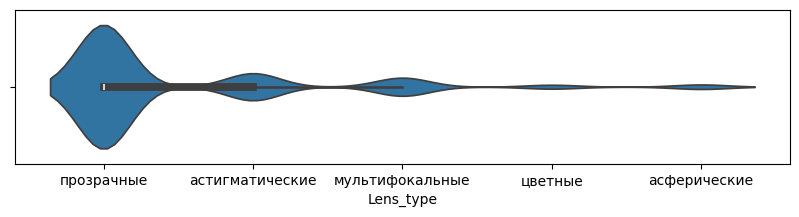

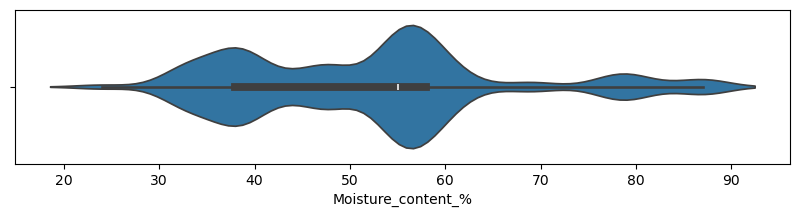

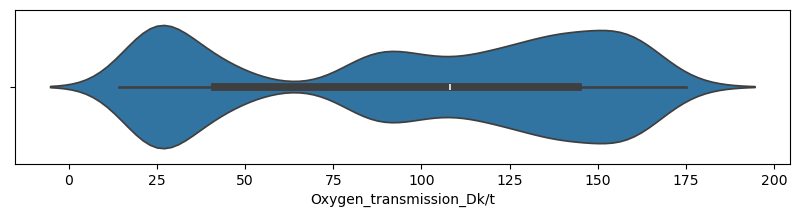

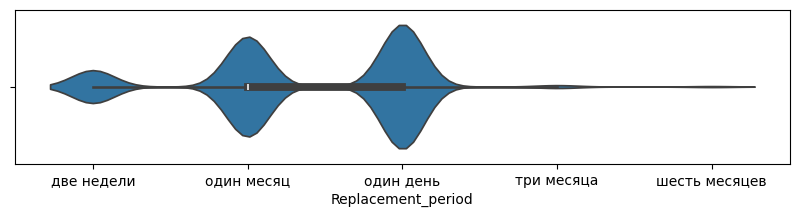

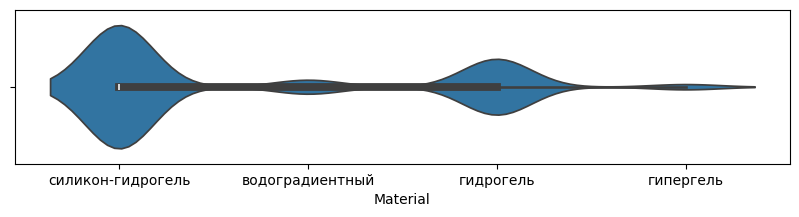

In [46]:
for col in df.columns:
    plt.figure(figsize=(10, 2))
    sns.violinplot(x=df[col])
    plt.show()

#### Преобразование нецелевых категорий

##### One-hot Encoding

In [57]:
categorical_features = ['Replacement_period', 'Lens_type', 'Manufacturer', 'Material', 'Brand']

# Создаем и обучаем OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_features])

# Преобразование в DataFrame для удобства
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

encoded_df.index = df.index

# Объединяем закодированные признаки с числовыми
df = pd.concat([df.drop(columns=categorical_features), encoded_df], axis=1)

In [58]:
df.shape

(4063, 55)

#### Отбор признаков

##### Удаление константных и псевдоконстантных (почти константных) признаков

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4063 entries, 0 to 51380
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Package_quantity_pieces           4063 non-null   int64  
 1   Optical_power                     4063 non-null   float64
 2   Price_rub                         4063 non-null   int64  
 3   MKL_Diameter_mm                   4063 non-null   float64
 4   Moisture_content_%                4063 non-null   float64
 5   Oxygen_transmission_Dk/t          4063 non-null   float64
 6   Replacement_period_две недели     4063 non-null   float64
 7   Replacement_period_один день      4063 non-null   float64
 8   Replacement_period_один месяц     4063 non-null   float64
 9   Replacement_period_три месяца     4063 non-null   float64
 10  Replacement_period_шесть месяцев  4063 non-null   float64
 11  Lens_type_астигматические         4063 non-null   float64
 12  Lens_type_

In [62]:
X = df.drop(columns=['Package_quantity_pieces'])
selector = VarianceThreshold(threshold=0.015)
selector.fit(X)
# Значения дисперсий для каждого признака
variances = selector.variances_
for var in variances:
    print(f"{var:.2f}")

25.37
2996673.48
0.02
205.65
2644.09
0.11
0.25
0.24
0.01
0.00
0.13
0.02
0.09
0.21
0.02
0.18
0.13
0.03
0.19
0.18
0.00
0.00
0.06
0.03
0.00
0.07
0.20
0.03
0.24
0.18
0.09
0.00
0.03
0.02
0.08
0.01
0.05
0.06
0.03
0.06
0.00
0.00
0.00
0.04
0.04
0.01
0.03
0.04
0.01
0.03
0.01
0.04
0.03
0.03


In [63]:
X.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Replacement_period_три месяца,Replacement_period_шесть месяцев,...,Brand_myday,Brand_optima,Brand_optosoft,Brand_precision,Brand_premio,Brand_proclear,Brand_purevision,Brand_soflens,Brand_total,Brand_ultra
0,-1.00,1680,14.0,38.0,147.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.00,1380,14.2,33.0,138.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.00,2120,14.2,55.0,154.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.25,2580,14.5,87.0,90.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.00,2580,14.2,55.0,123.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
# Константный и псевдоконстантный признаки удалены
selector.transform(X)

array([[-1.00e+00,  1.68e+03,  1.40e+01, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [-1.00e+00,  1.38e+03,  1.42e+01, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [-1.00e+00,  2.12e+03,  1.42e+01, ...,  0.00e+00,  1.00e+00,
         0.00e+00],
       ...,
       [-7.00e+00,  4.78e+03,  1.42e+01, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [-4.00e+00,  4.78e+03,  1.42e+01, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [ 4.00e+00,  4.78e+03,  1.42e+01, ...,  0.00e+00,  0.00e+00,
         0.00e+00]])

In [65]:
mask = selector.get_support()

In [66]:
selected_columns = X.columns[mask]
selected_columns

Index(['Optical_power', 'Price_rub', 'MKL_Diameter_mm', 'Moisture_content_%',
       'Oxygen_transmission_Dk/t', 'Replacement_period_две недели',
       'Replacement_period_один день', 'Replacement_period_один месяц',
       'Lens_type_астигматические', 'Lens_type_асферические',
       'Lens_type_мультифокальные', 'Lens_type_прозрачные',
       'Lens_type_цветные', 'Manufacturer_alcon', 'Manufacturer_bausch&lomb',
       'Manufacturer_clearlab', 'Manufacturer_coopervision',
       'Manufacturer_johnson&johnson', 'Manufacturer_menicon',
       'Manufacturer_optosoft', 'Material_водоградиентный',
       'Material_гидрогель', 'Material_гипергель',
       'Material_силикон-гидрогель', 'Brand_acuvue', 'Brand_airoptix',
       'Brand_avaira', 'Brand_bausch&lomb', 'Brand_biofinity', 'Brand_biotruе',
       'Brand_clariti', 'Brand_clear', 'Brand_dailies', 'Brand_miru',
       'Brand_myday', 'Brand_optosoft', 'Brand_precision', 'Brand_proclear',
       'Brand_soflens', 'Brand_total', 'Brand_ult

In [67]:
dropped_columns = X.columns[~mask]
dropped_columns

Index(['Replacement_period_три месяца', 'Replacement_period_шесть месяцев',
       'Manufacturer_maximaoptics', 'Manufacturer_maxlook',
       'Manufacturer_uniconopticalco', 'Brand_amore', 'Brand_biomedics',
       'Brand_freshlook', 'Brand_iqlens', 'Brand_maxima', 'Brand_optima',
       'Brand_premio', 'Brand_purevision'],
      dtype='object')

In [68]:
df.drop(columns = dropped_columns, axis = 1, inplace = True)

In [69]:
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Lens_type_астигматические,...,Brand_clear,Brand_dailies,Brand_miru,Brand_myday,Brand_optosoft,Brand_precision,Brand_proclear,Brand_soflens,Brand_total,Brand_ultra
0,0,-1.00,1680,14.0,38.0,147.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-1.00,1380,14.2,33.0,138.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-1.00,2120,14.2,55.0,154.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,-1.25,2580,14.5,87.0,90.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,-1.00,2580,14.2,55.0,123.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Удаление повторяющихся признаков

In [71]:
def get_duplicates(X):
    """
    Поиск дубликатов в колонках
    X - DataFrame
    """
    
    pairs = {}
    dups = []

    # Перебор всех колонок (внешний)
    for i in range(X.shape[1]):

        # текущая колонка
        feat_outer = X.columns[i]

        # если текущая колонка не является дублем
        if feat_outer not in dups:

            # создаем запись в словаре, колонка является ключом
            pairs[feat_outer] = []

            # Перебор оставшихся колонок (внутренний)
            for feat_inner in X.columns[i + 1:]:

                # Если колонки идентичны
                if X[feat_outer].equals(X[feat_inner]):

                    # добавление в словарь и список дубликатов
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)

    return pairs

In [72]:
get_duplicates(df)

{'Package_quantity_pieces': [],
 'Optical_power': [],
 'Price_rub': [],
 'MKL_Diameter_mm': [],
 'Moisture_content_%': [],
 'Oxygen_transmission_Dk/t': [],
 'Replacement_period_две недели': [],
 'Replacement_period_один день': [],
 'Replacement_period_один месяц': [],
 'Lens_type_астигматические': [],
 'Lens_type_асферические': [],
 'Lens_type_мультифокальные': [],
 'Lens_type_прозрачные': [],
 'Lens_type_цветные': [],
 'Manufacturer_alcon': [],
 'Manufacturer_bausch&lomb': [],
 'Manufacturer_clearlab': ['Brand_clear'],
 'Manufacturer_coopervision': [],
 'Manufacturer_johnson&johnson': ['Brand_acuvue'],
 'Manufacturer_menicon': [],
 'Manufacturer_optosoft': ['Brand_optosoft'],
 'Material_водоградиентный': [],
 'Material_гидрогель': [],
 'Material_гипергель': [],
 'Material_силикон-гидрогель': [],
 'Brand_airoptix': [],
 'Brand_avaira': [],
 'Brand_bausch&lomb': [],
 'Brand_biofinity': [],
 'Brand_biotruе': [],
 'Brand_clariti': [],
 'Brand_dailies': [],
 'Brand_miru': [],
 'Brand_myday

In [73]:
dropped_columns = ['Brand_acuvue', 'Brand_clear', 'Brand_optosoft']
df.drop(columns = dropped_columns, axis = 1, inplace = True) 

##### Методы, основанные на корреляции

<Axes: >

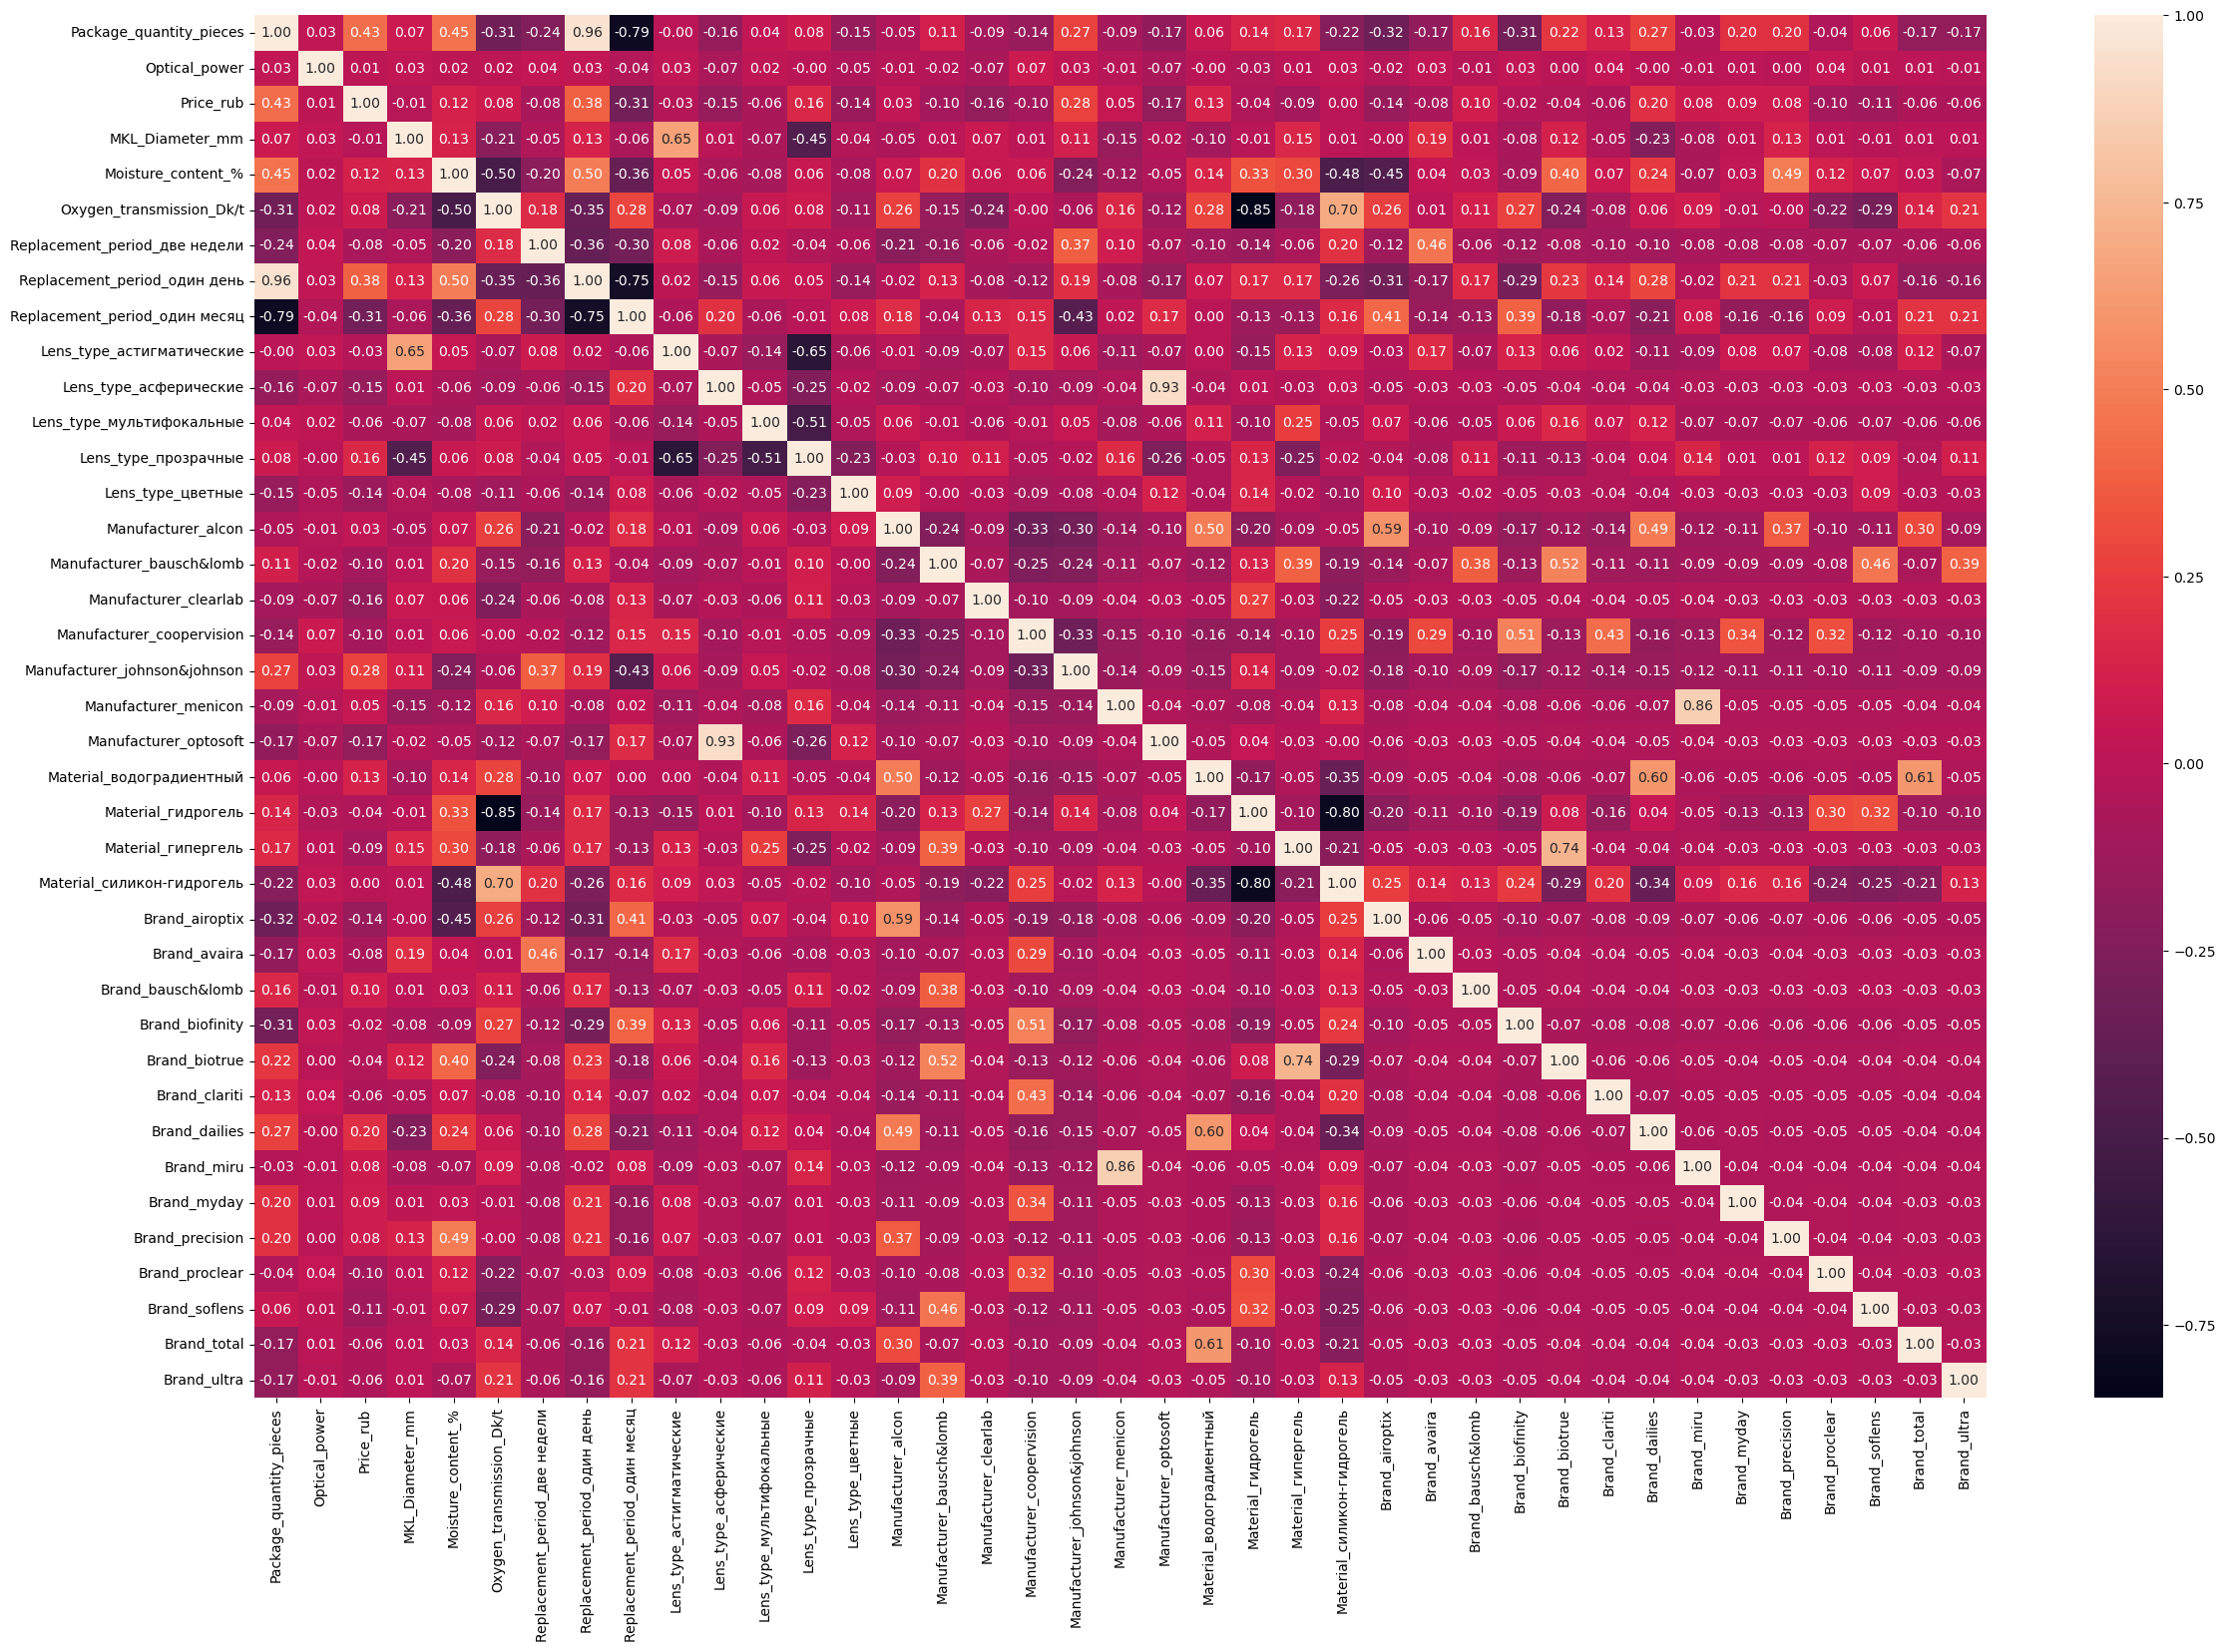

In [75]:
plt.figure(figsize=(28, 18))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [76]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.8]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [77]:
make_corr_df(df)

,f1,f2,corr
0,Package_quantity_pieces,Replacement_period_один день,0.955223
1,Replacement_period_один день,Package_quantity_pieces,0.955223
2,Manufacturer_optosoft,Lens_type_асферические,0.932510
3,Lens_type_асферические,Manufacturer_optosoft,0.932510
4,Brand_miru,Manufacturer_menicon,0.858108
5,Manufacturer_menicon,Brand_miru,0.858108
6,Oxygen_transmission_Dk/t,Material_гидрогель,0.847789
7,Material_гидрогель,Oxygen_transmission_Dk/t,0.847789
8,Material_гидрогель,Material_силикон-гидрогель,0.802068
9,Material_силикон-гидрогель,Material_гидрогель,0.802068


In [78]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [79]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(df))

[['Replacement_period_один день', 'Package_quantity_pieces'],
 ['Lens_type_асферические', 'Manufacturer_optosoft'],
 ['Manufacturer_menicon', 'Brand_miru'],
 ['Material_гидрогель', 'Oxygen_transmission_Dk/t'],
 ['Material_гидрогель', 'Material_силикон-гидрогель']]

In [81]:
dropped_columns = ['Lens_type_асферические', 'Brand_miru', 'Material_силикон-гидрогель', 'Material_гидрогель']
df.drop(columns = dropped_columns, axis = 1, inplace = True) 

In [82]:
# Удалим дубликаты записей, если они присутствуют
df = df.drop_duplicates()
df.shape

(4063, 35)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4063 entries, 0 to 51380
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Package_quantity_pieces        4063 non-null   int64  
 1   Optical_power                  4063 non-null   float64
 2   Price_rub                      4063 non-null   int64  
 3   MKL_Diameter_mm                4063 non-null   float64
 4   Moisture_content_%             4063 non-null   float64
 5   Oxygen_transmission_Dk/t       4063 non-null   float64
 6   Replacement_period_две недели  4063 non-null   float64
 7   Replacement_period_один день   4063 non-null   float64
 8   Replacement_period_один месяц  4063 non-null   float64
 9   Lens_type_астигматические      4063 non-null   float64
 10  Lens_type_мультифокальные      4063 non-null   float64
 11  Lens_type_прозрачные           4063 non-null   float64
 12  Lens_type_цветные              4063 non-null   float

In [84]:
df['Package_quantity_pieces'].value_counts()

Package_quantity_pieces
1    2032
0    2031
Name: count, dtype: int64

## 2. Деревья решений и ансамбли

In [86]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, ParameterGrid, KFold
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, log_loss, hinge_loss
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.colors as mcolors
from collections import Counter, defaultdict
from sklearn.utils import resample

In [87]:
# Преобразуем целевой признак для классификации
df_tree = df.copy()
y = df_tree.Package_quantity_pieces
X = df_tree[df_tree.columns.difference(['Package_quantity_pieces'])]

### 1) Дерево принятия решений

### Библиотечная реализация дерева принятия решений

In [90]:
# Разделим данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2437, 34) (2437,)
(1626, 34) (1626,)


#### Переберор значений числовых гиперпараметров

In [92]:
param_grid = {
    'min_samples_split': [2, 5, 10, 20, 50], #Количество образцов, которые должны быть в узле для того, чтобы дерево могло его разделить
    'min_samples_leaf': [1, 2, 5, 10, 20, 50], #Устанавливает минимальное количество образцов в каждом листе дерева
    'max_leaf_nodes': [2, 3, 5, 10, 25, 50, 100] #Ограничивает максимальное количество листьев в дереве
}

In [93]:
# Сохраним результаты
results = []

for min_samples_split in param_grid['min_samples_split']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
        for max_leaf_nodes in param_grid['max_leaf_nodes']:
            model = DecisionTreeClassifier(
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_leaf_nodes=max_leaf_nodes,
                random_state=42
            )
            model.fit(X_train, y_train)
            # Предсказания для оценки качества
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Метрики
            train_f1_score = f1_score(y_train, y_train_pred)
            test_f1_score = f1_score(y_test, y_test_pred)
            
            # Сохранение высоты дерева, количества листьев и метрик
            tree_depth = model.tree_.max_depth
            n_leaves = model.tree_.n_leaves
            
            results.append({
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'tree_depth': tree_depth,
                'n_leaves': n_leaves,
                'train_f1_score': train_f1_score,
                'test_f1_score': test_f1_score
            })

In [94]:
results_df_base = pd.DataFrame(results)
print("Уникальные значения глубины дерева:", results_df_base['tree_depth'].unique())
print("Уникальные значения метрик качества на тренировочной выборке:", results_df_base['train_f1_score'].unique())
print("Уникальные значения метрик качества на тестовой выборке:", results_df_base['test_f1_score'].unique())

Уникальные значения глубины дерева: [1 2 4 3]
Уникальные значения метрик качества на тренировочной выборке: [0.97606048 0.98922056 1.        ]
Уникальные значения метрик качества на тестовой выборке: [0.97735849 0.98817673 1.        ]


#### График зависимости высоты полученного дерева

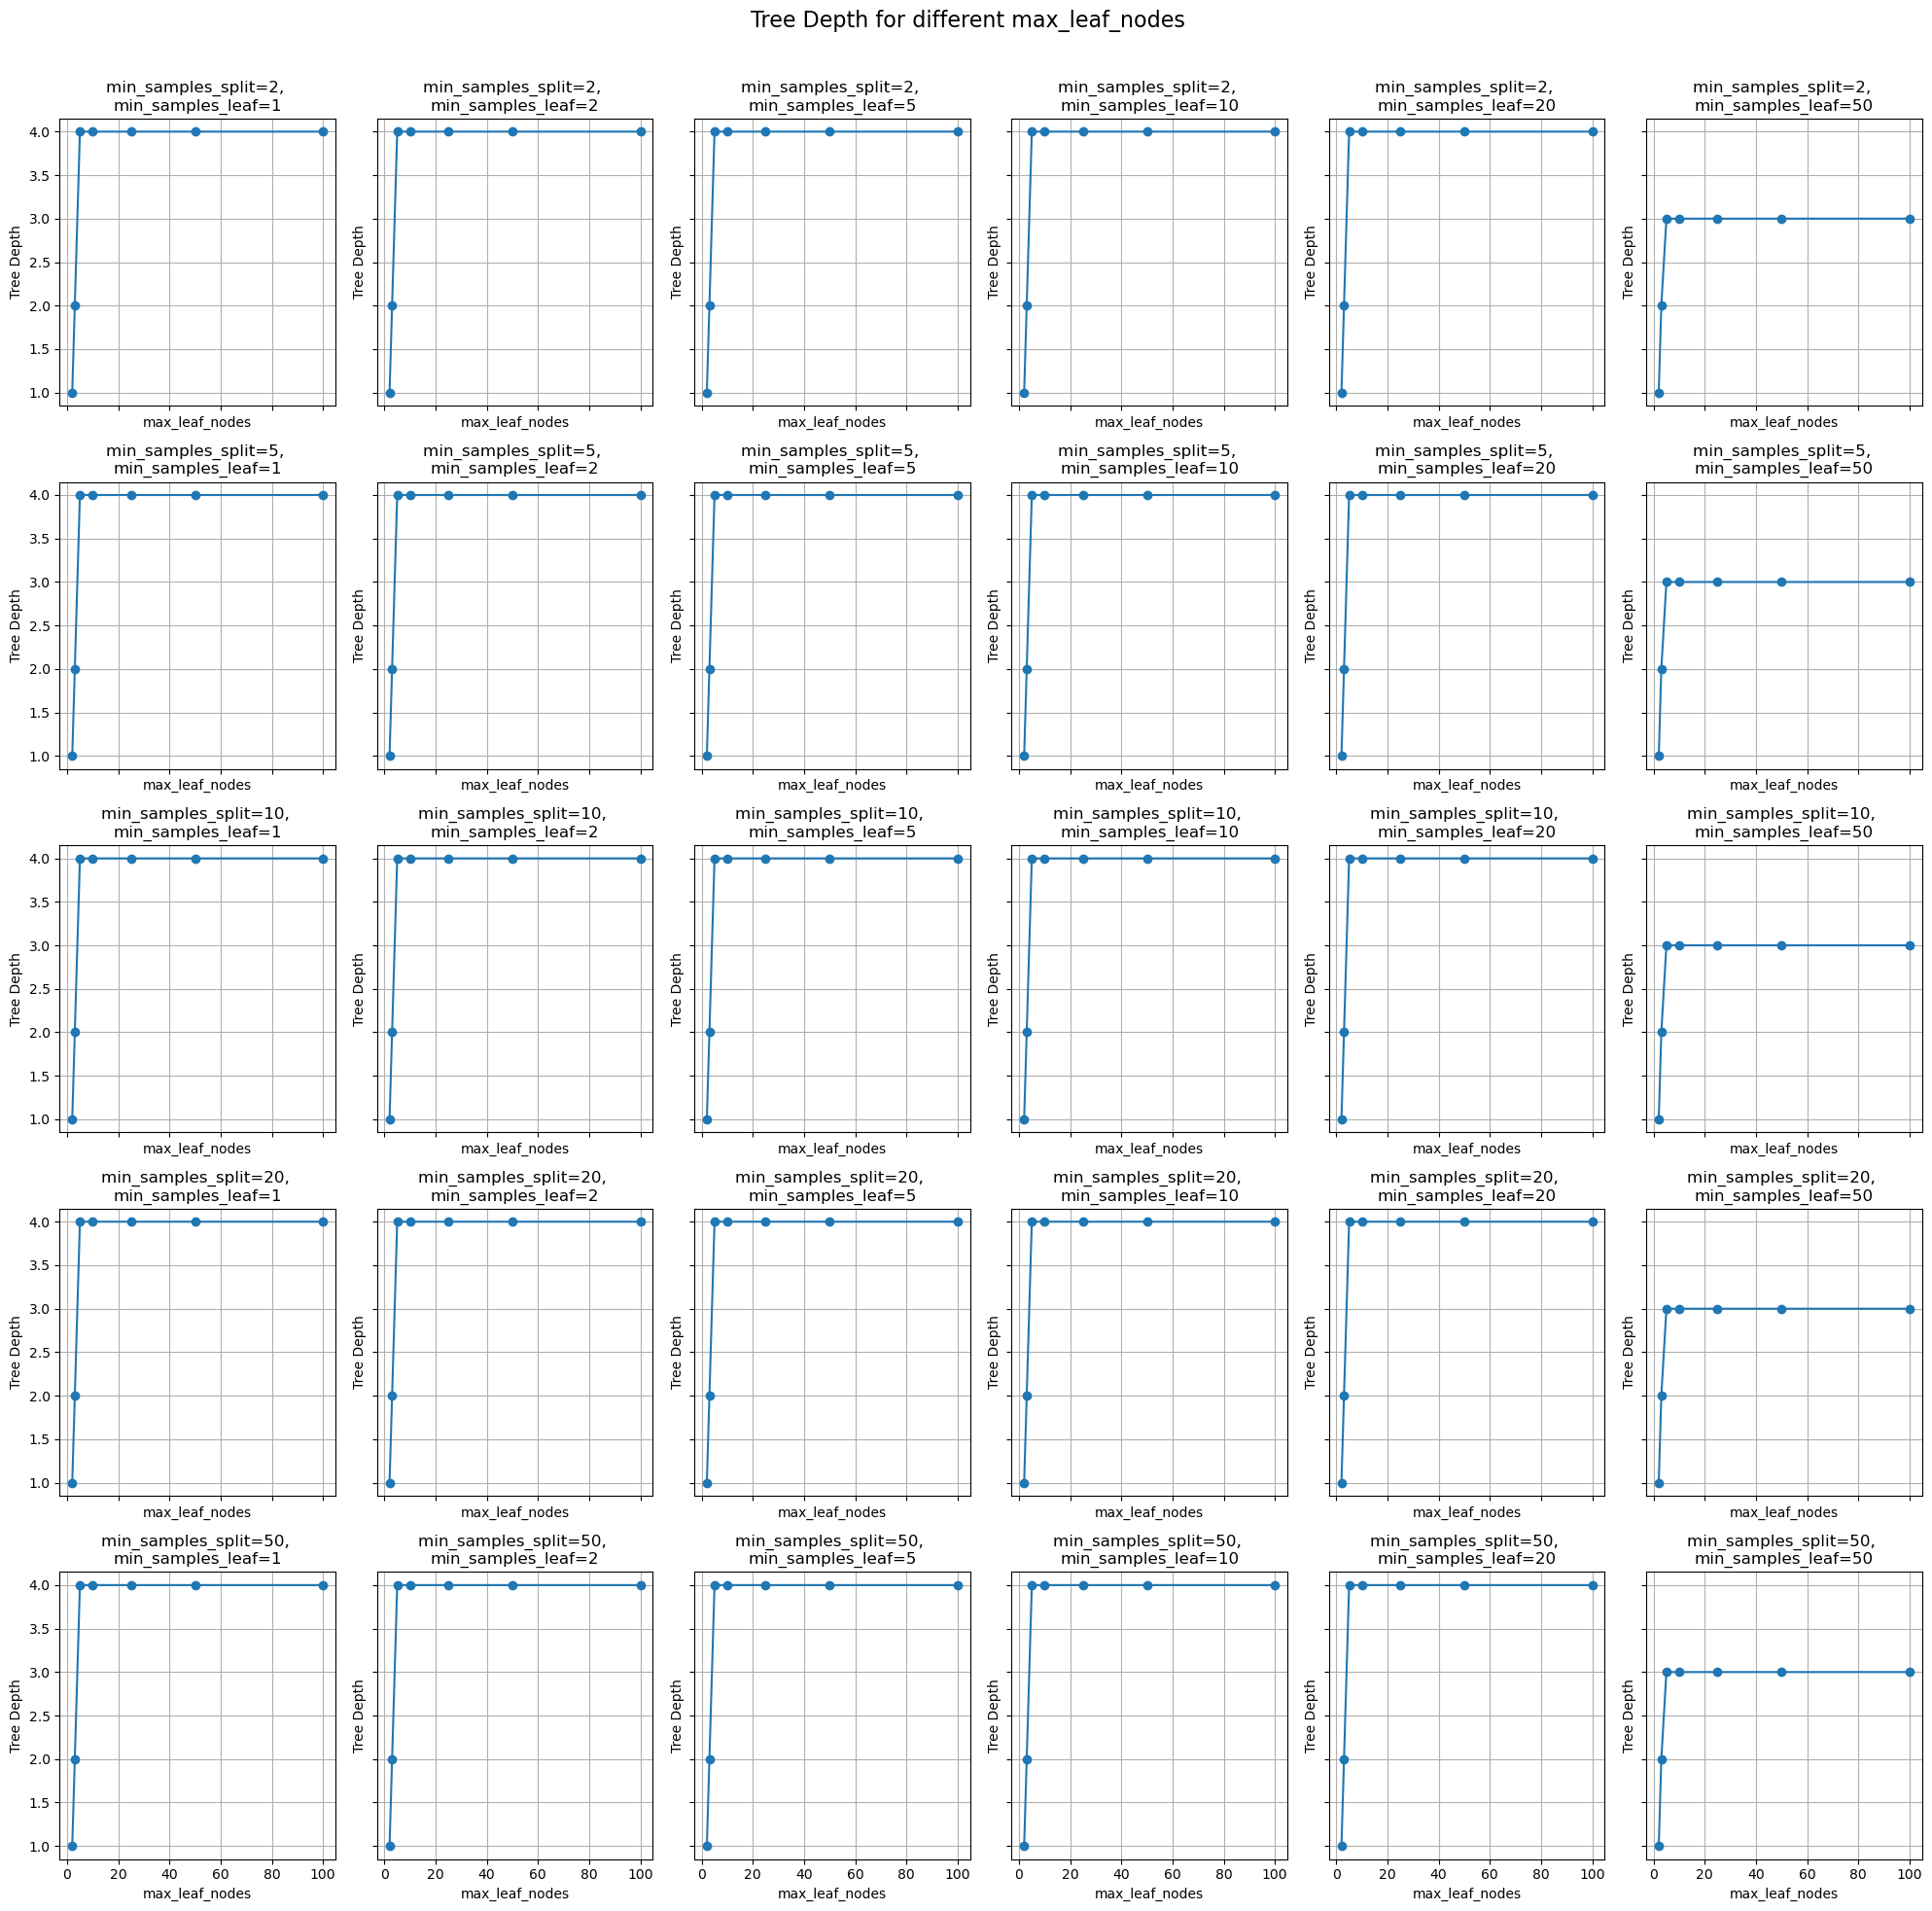

In [99]:
# Перебираем все комбинации двух фиксированных параметров
varied_param = 'max_leaf_nodes'
fixed_params_keys = [key for key in param_grid.keys() if key != varied_param]

# Построение графиков
fig, axes = plt.subplots(
    len(param_grid[fixed_params_keys[0]]),
    len(param_grid[fixed_params_keys[1]]),
    figsize=(20, 20),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, fixed_param_1_value in enumerate(param_grid[fixed_params_keys[0]]):
    for j, fixed_param_2_value in enumerate(param_grid[fixed_params_keys[1]]):
        # Индекс текущего графика
        ax = axes[i * len(param_grid[fixed_params_keys[1]]) + j]

        # Результаты для текущей комбинации
        results = []

        for value in param_grid[varied_param]:
            model = DecisionTreeClassifier(
                random_state=42,
                **{fixed_params_keys[0]: fixed_param_1_value, fixed_params_keys[1]: fixed_param_2_value},
                **{varied_param: value}
            )
            model.fit(X_train, y_train)

            # Сохраняем высоту дерева
            tree_depth = model.tree_.max_depth
            results.append({'varied_param_value': value, 'tree_depth': tree_depth})

        # Преобразование в DataFrame
        results_df = pd.DataFrame(results)

        # Построение графика
        ax.plot(results_df['varied_param_value'], results_df['tree_depth'], marker='o')
        ax.set_title(f"{fixed_params_keys[0]}={fixed_param_1_value}, \n{fixed_params_keys[1]}={fixed_param_2_value}")
        ax.set_xlabel(varied_param)
        ax.set_ylabel('Tree Depth')
        ax.grid(True)

# Общий заголовок
plt.suptitle("Tree Depth for different max_leaf_nodes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

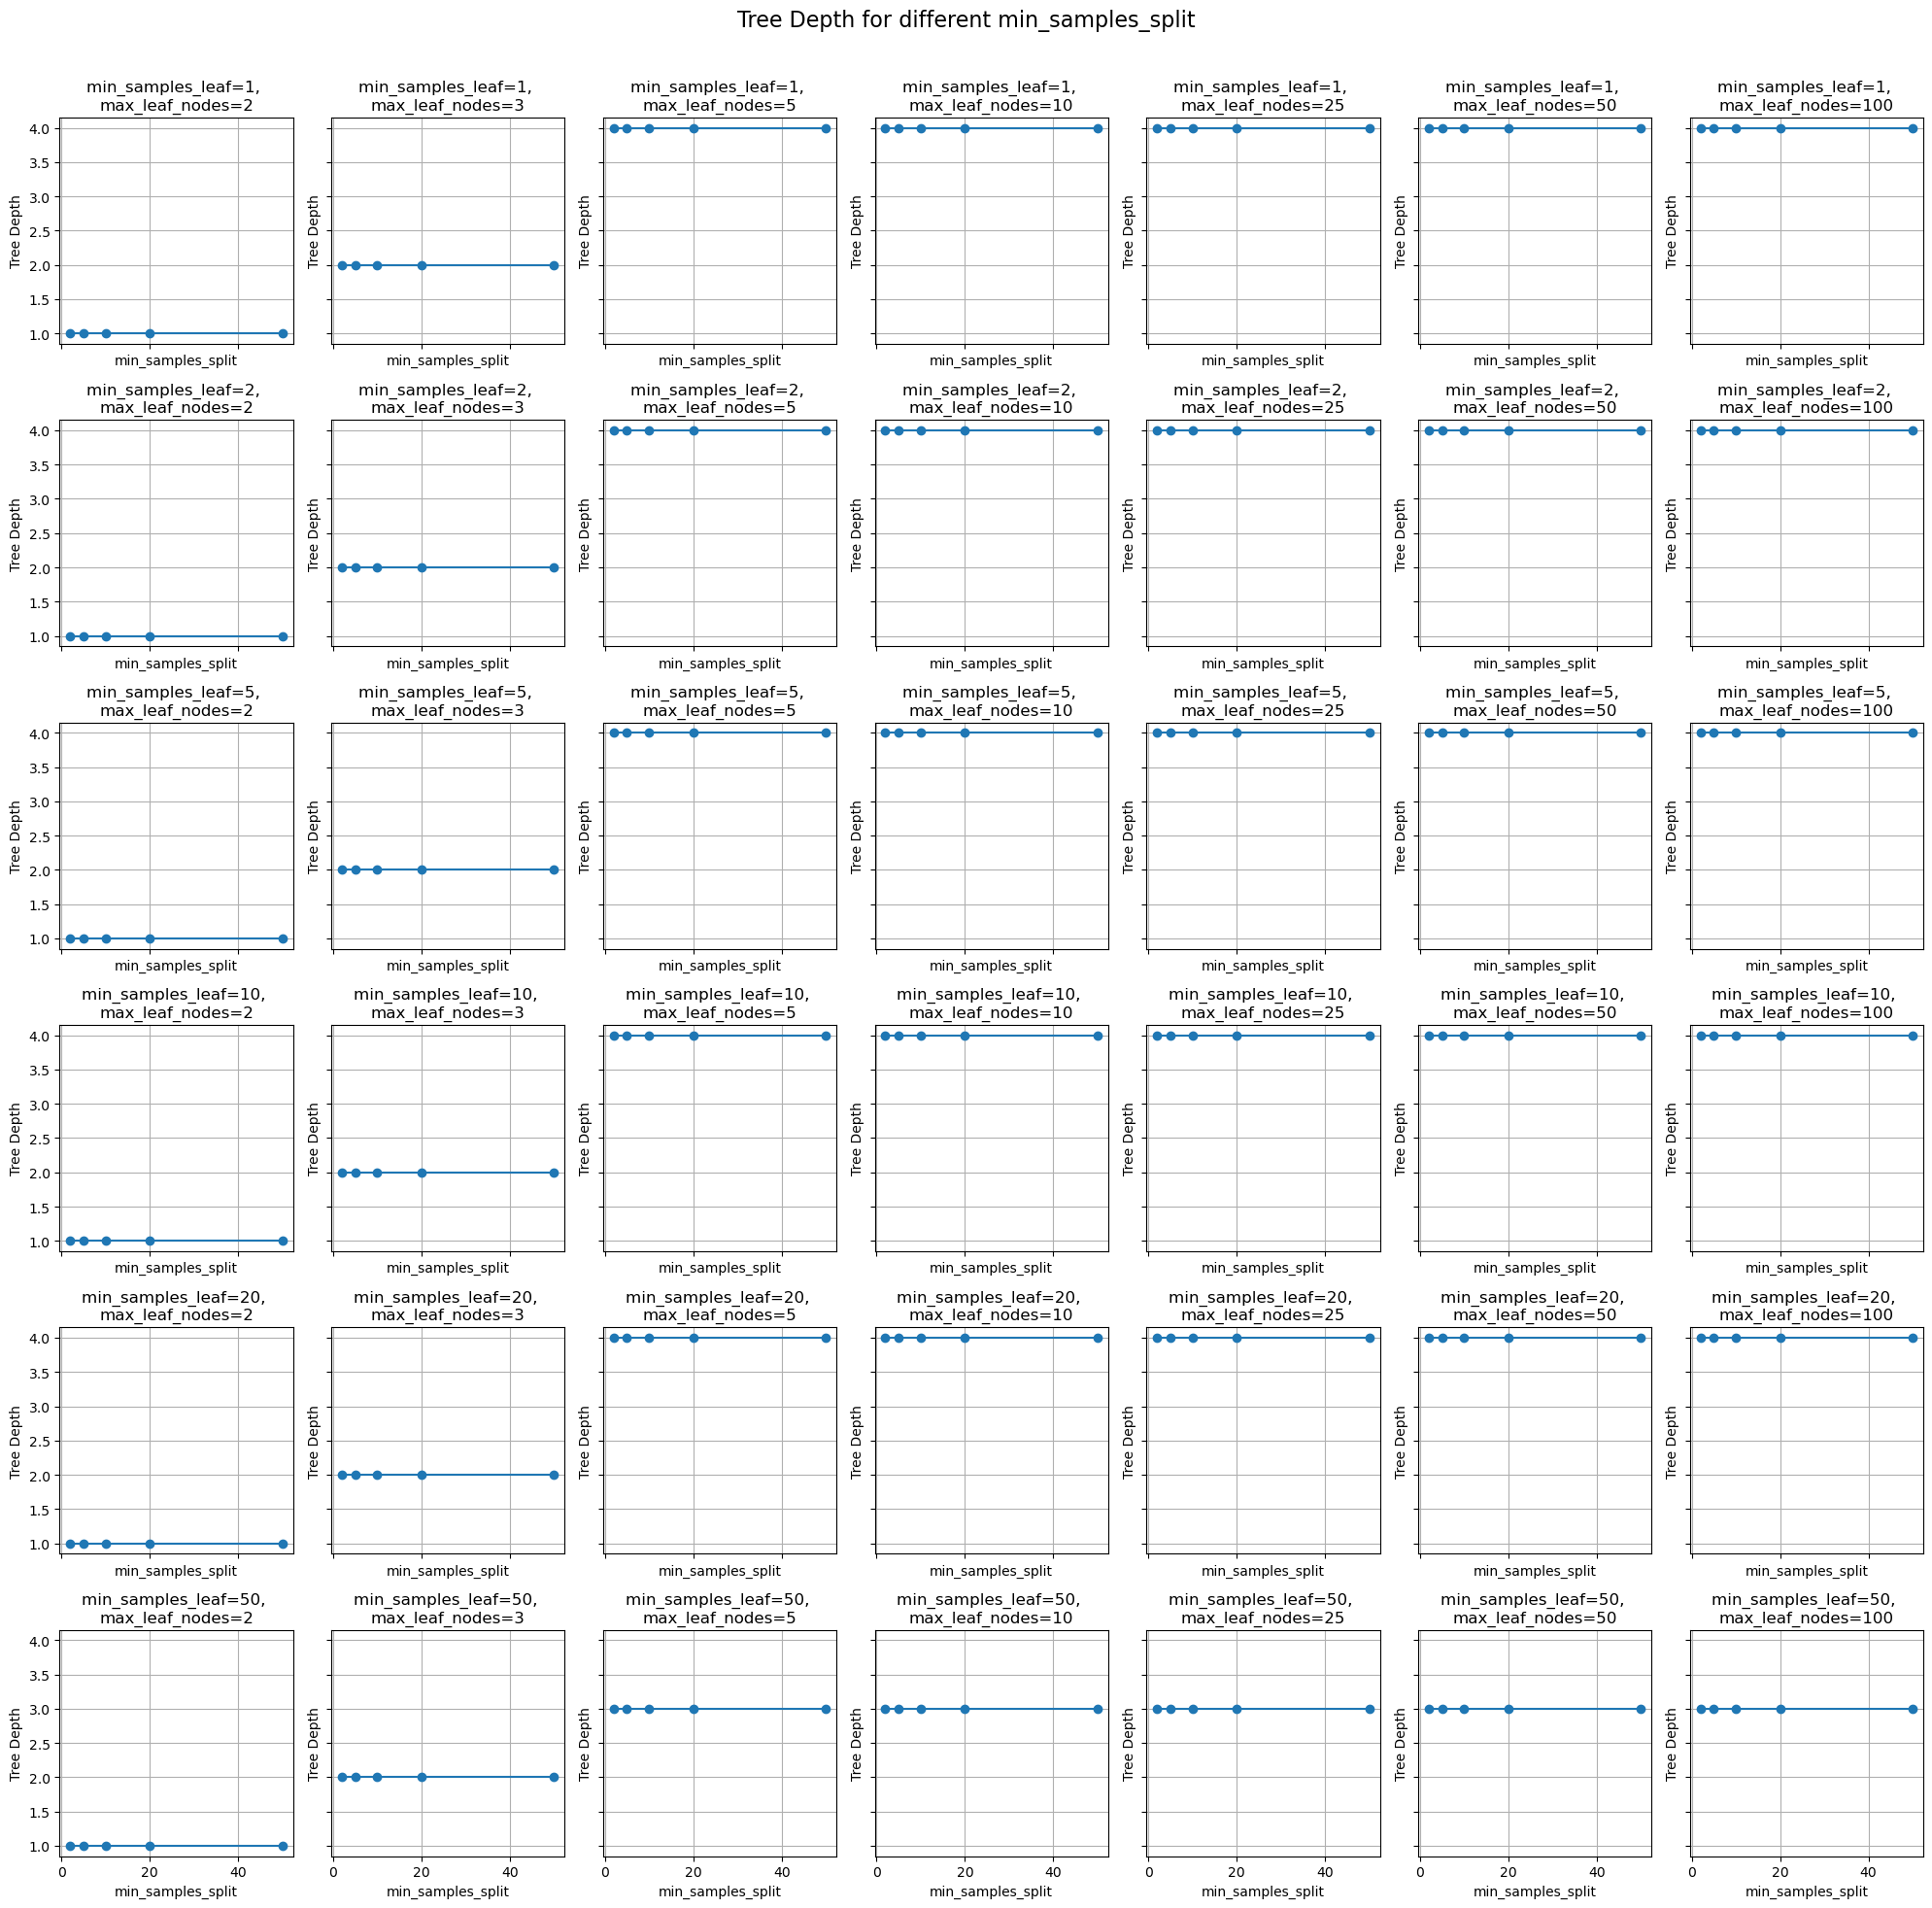

In [100]:
# Перебираем все комбинации двух фиксированных параметров
varied_param = 'min_samples_split'
fixed_params_keys = [key for key in param_grid.keys() if key != varied_param]

# Построение графиков
fig, axes = plt.subplots(
    len(param_grid[fixed_params_keys[0]]),
    len(param_grid[fixed_params_keys[1]]),
    figsize=(20, 20),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, fixed_param_1_value in enumerate(param_grid[fixed_params_keys[0]]):
    for j, fixed_param_2_value in enumerate(param_grid[fixed_params_keys[1]]):
        # Индекс текущего графика
        ax = axes[i * len(param_grid[fixed_params_keys[1]]) + j]

        # Результаты для текущей комбинации
        results = []

        for value in param_grid[varied_param]:
            model = DecisionTreeClassifier(
                random_state=42,
                **{fixed_params_keys[0]: fixed_param_1_value, fixed_params_keys[1]: fixed_param_2_value},
                **{varied_param: value}
            )
            model.fit(X_train, y_train)

            # Сохраняем высоту дерева
            tree_depth = model.tree_.max_depth
            results.append({'varied_param_value': value, 'tree_depth': tree_depth})

        # Преобразование в DataFrame
        results_df = pd.DataFrame(results)

        # Построение графика
        ax.plot(results_df['varied_param_value'], results_df['tree_depth'], marker='o')
        ax.set_title(f"{fixed_params_keys[0]}={fixed_param_1_value}, \n{fixed_params_keys[1]}={fixed_param_2_value}")
        ax.set_xlabel(varied_param)
        ax.set_ylabel('Tree Depth')
        ax.grid(True)

# Общий заголовок
plt.suptitle("Tree Depth for different min_samples_split", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

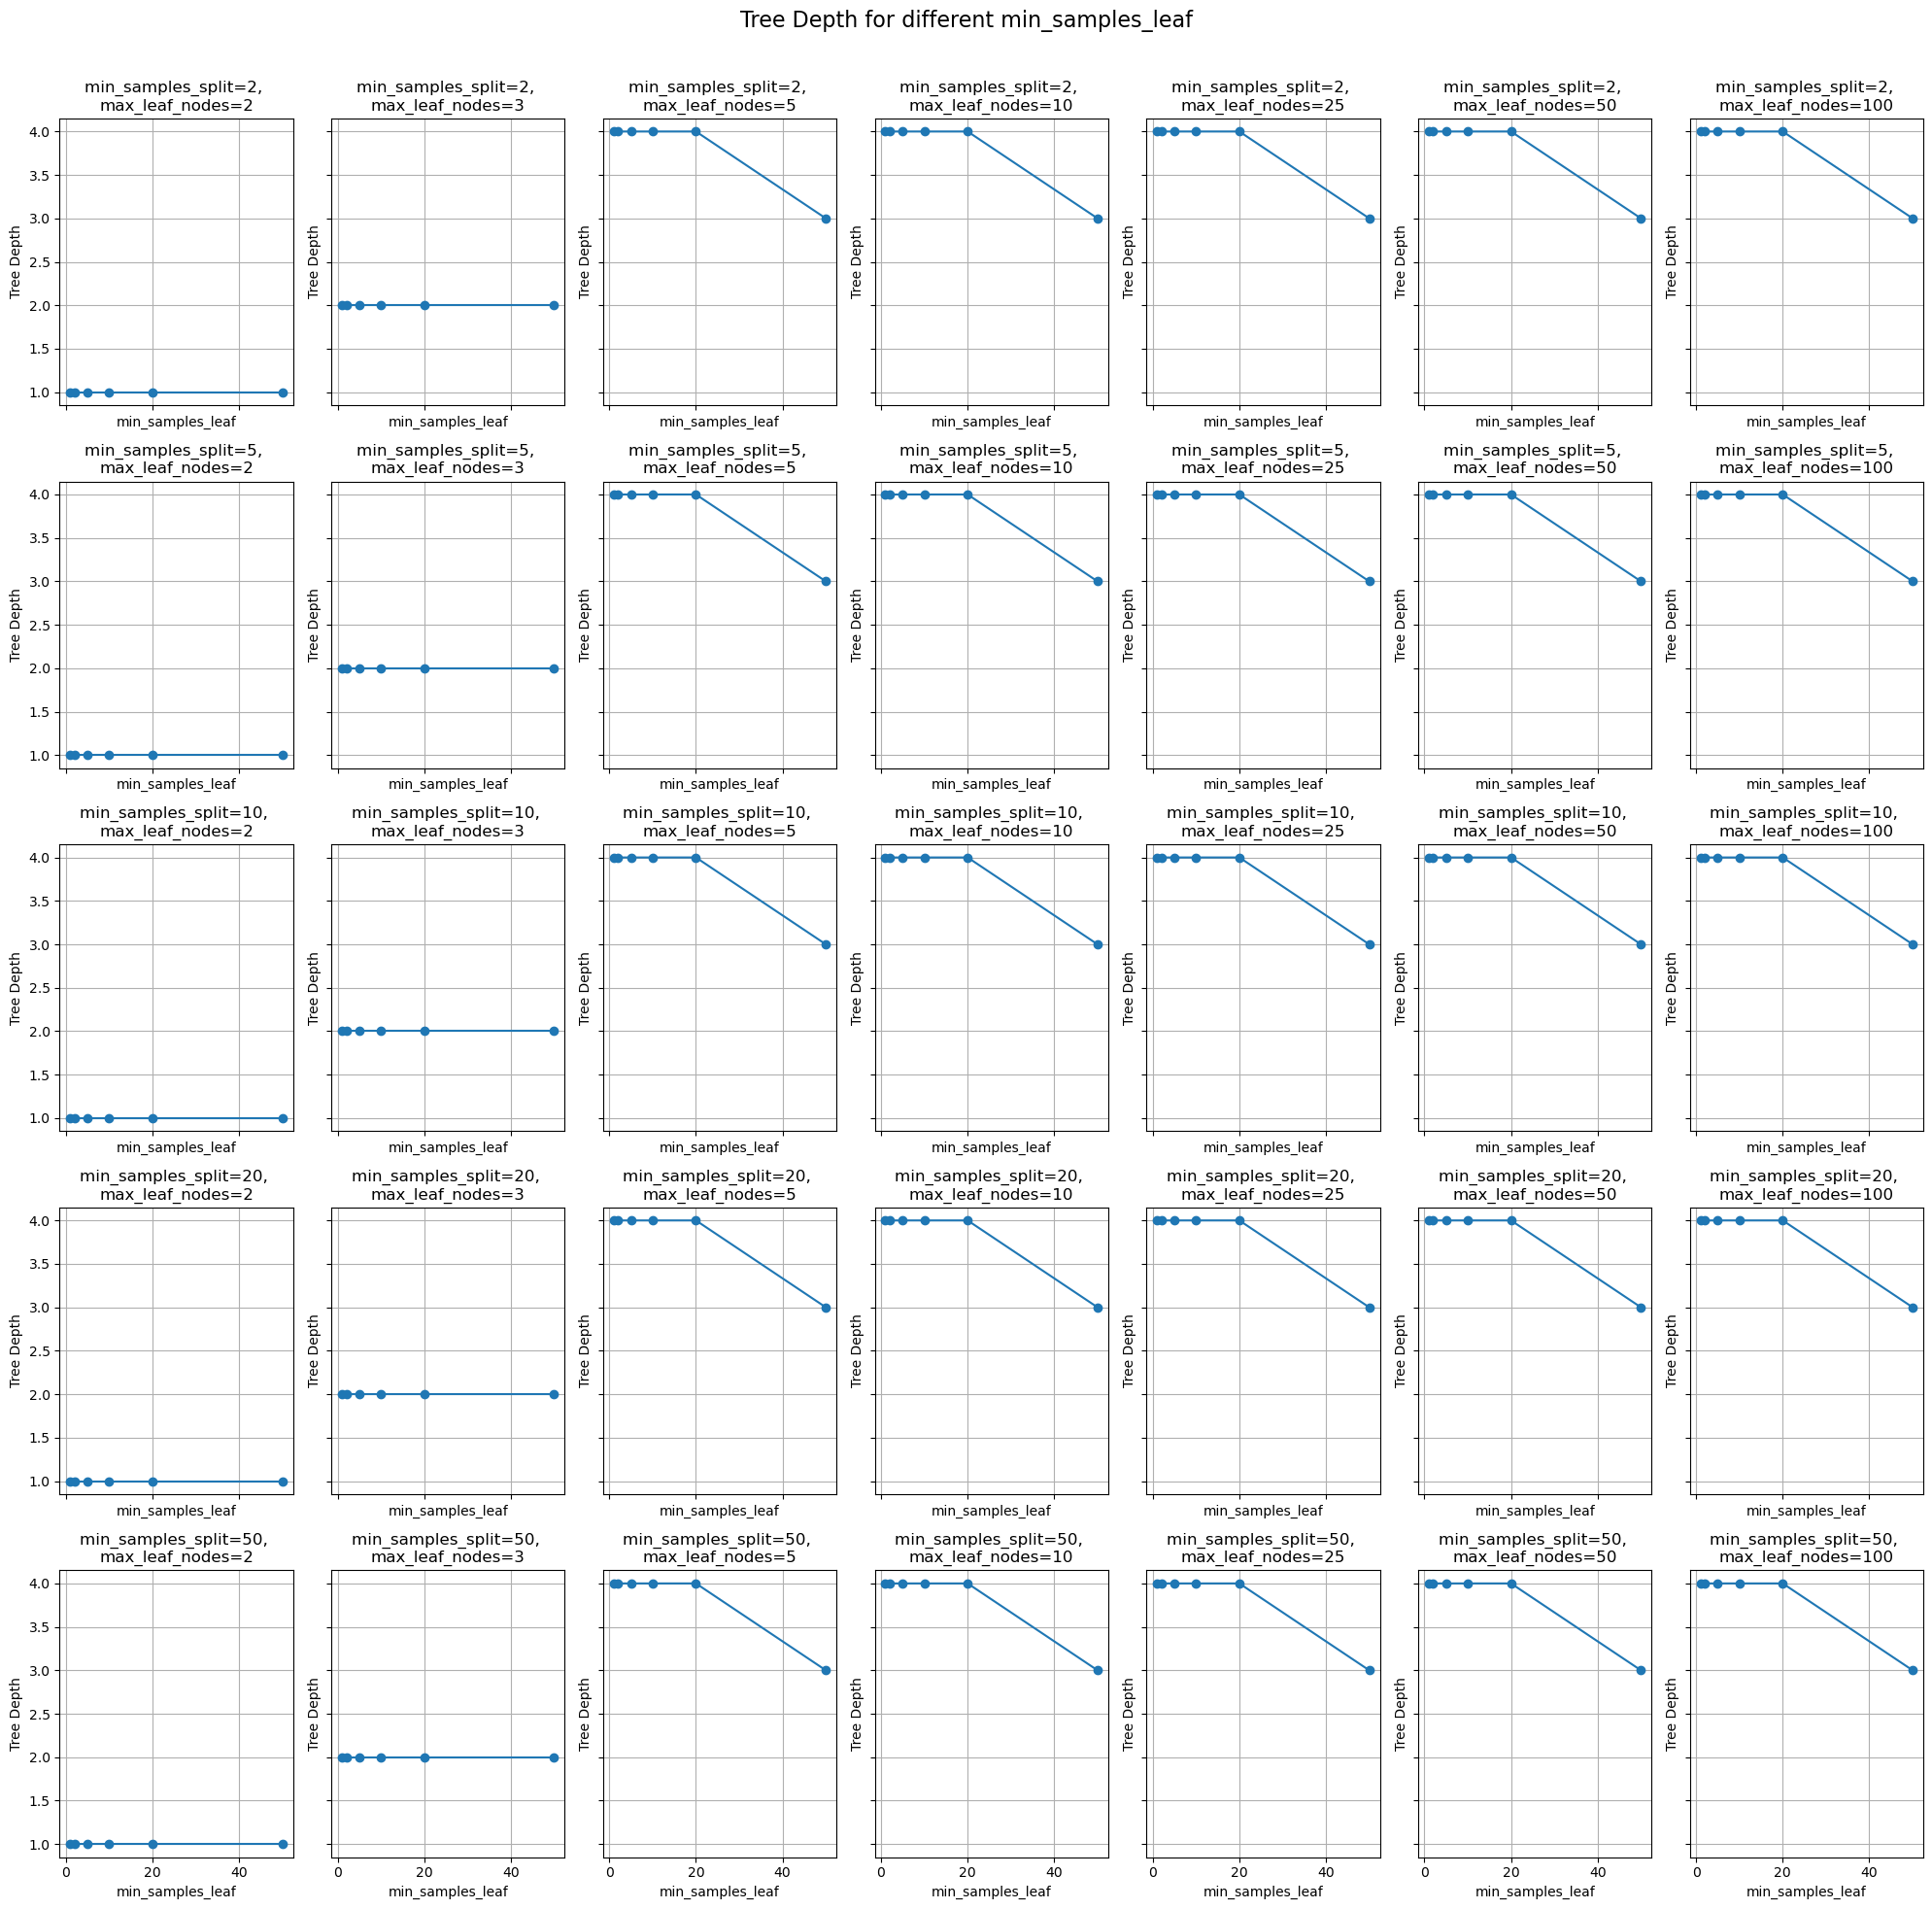

In [101]:
# Перебираем все комбинации двух фиксированных параметров
varied_param = 'min_samples_leaf'
fixed_params_keys = [key for key in param_grid.keys() if key != varied_param]

# Построение графиков
fig, axes = plt.subplots(
    len(param_grid[fixed_params_keys[0]]),
    len(param_grid[fixed_params_keys[1]]),
    figsize=(20, 20),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, fixed_param_1_value in enumerate(param_grid[fixed_params_keys[0]]):
    for j, fixed_param_2_value in enumerate(param_grid[fixed_params_keys[1]]):
        # Индекс текущего графика
        ax = axes[i * len(param_grid[fixed_params_keys[1]]) + j]

        # Результаты для текущей комбинации
        results = []

        for value in param_grid[varied_param]:
            model = DecisionTreeClassifier(
                random_state=42,
                **{fixed_params_keys[0]: fixed_param_1_value, fixed_params_keys[1]: fixed_param_2_value},
                **{varied_param: value}
            )
            model.fit(X_train, y_train)

            # Сохраняем высоту дерева
            tree_depth = model.tree_.max_depth
            results.append({'varied_param_value': value, 'tree_depth': tree_depth})

        # Преобразование в DataFrame
        results_df = pd.DataFrame(results)

        # Построение графика
        ax.plot(results_df['varied_param_value'], results_df['tree_depth'], marker='o')
        ax.set_title(f"{fixed_params_keys[0]}={fixed_param_1_value}, \n{fixed_params_keys[1]}={fixed_param_2_value}")
        ax.set_xlabel(varied_param)
        ax.set_ylabel('Tree Depth')
        ax.grid(True)

# Общий заголовок
plt.suptitle("Tree Depth for different min_samples_leaf", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

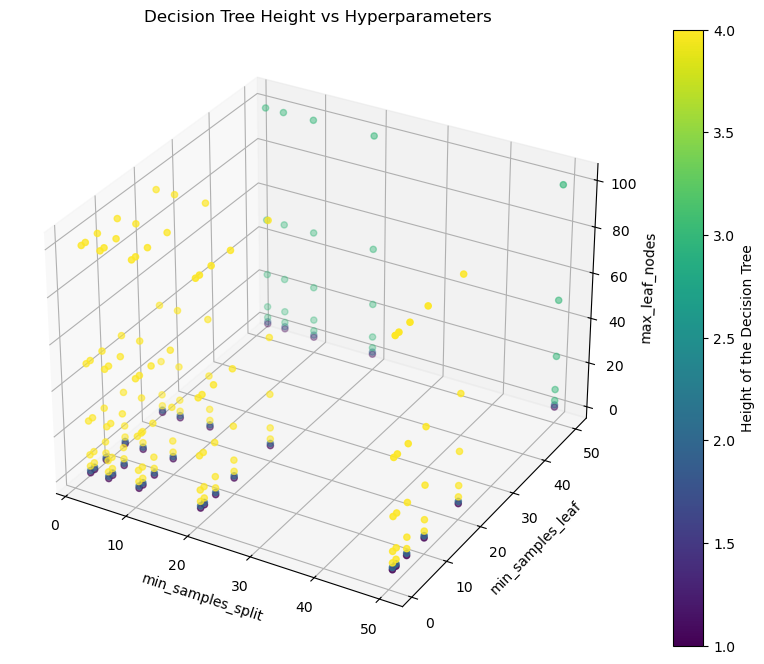

In [102]:
# Визуализация
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Проход по данным и построение точек
sc = ax.scatter(results_df_base['min_samples_split'], results_df_base['min_samples_leaf'], results_df_base['max_leaf_nodes'],
                c=results_df_base['tree_depth'], cmap='viridis')

# Настройки графика
ax.set_xlabel('min_samples_split')
ax.set_ylabel('min_samples_leaf')
ax.set_zlabel('max_leaf_nodes')
ax.set_title('Decision Tree Height vs Hyperparameters')
plt.colorbar(sc, label='Height of the Decision Tree')  # добавление цветовой шкалы
plt.grid()
plt.show()

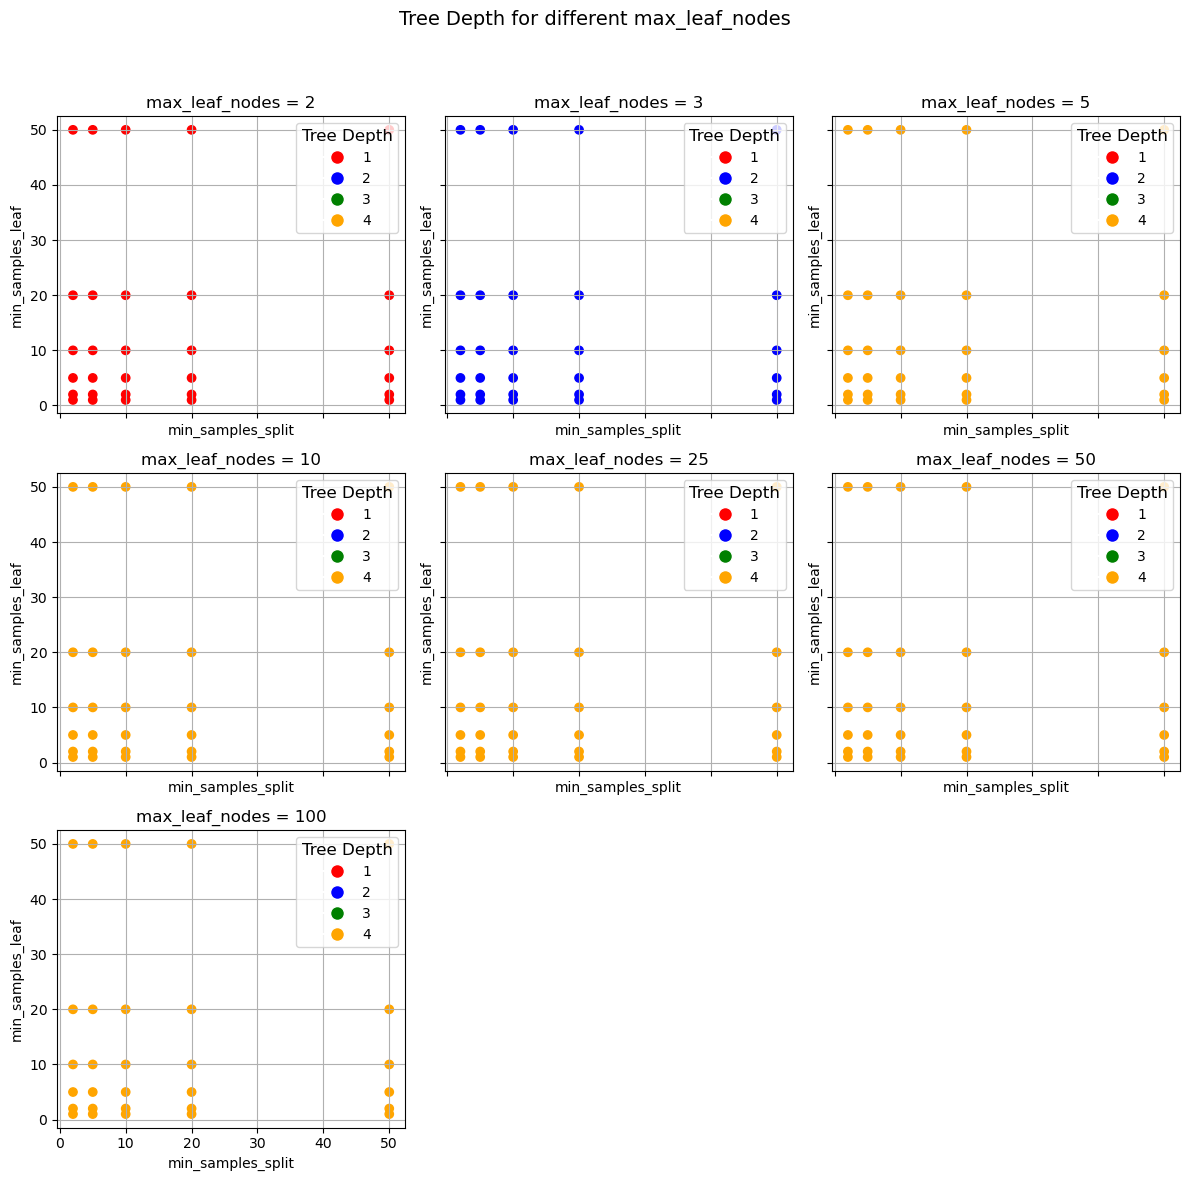

In [103]:
unique_max_leaf_nodes = results_df_base['max_leaf_nodes'].unique()

# Определяем количество строк и столбцов для компоновки графиков
ncols = 3  # Количество графиков в одной строке
nrows = (len(unique_max_leaf_nodes) + ncols - 1) // ncols  # Рассчитываем количество строк

# Дискретная цветовая палитра для tree_depth
# Например, 4 цвета для 4 различных значений глубины дерева
colors = ['red', 'blue', 'green', 'orange']
cmap = mcolors.ListedColormap(colors)

# Нормализация значений на 4 дискретных интервала
bounds = [i + 1 for i in range(results_df['tree_depth'].max())]  # Интервалы для tree_depth
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Визуализация 2D-графиков для каждого значения max_leaf_nodes
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 4 * nrows),
    sharex=True,
    sharey=True
)

axes = axes.flatten()  # Превращаем массив осей в плоский список

for i, max_leaf_nodes in enumerate(unique_max_leaf_nodes):
    subset = results_df_base[results_df_base['max_leaf_nodes'] == max_leaf_nodes]
    ax = axes[i]
    
    # Рисуем точки с дискретными цветами
    sc = ax.scatter(
        subset['min_samples_split'], 
        subset['min_samples_leaf'], 
        c=subset['tree_depth'], 
        cmap=cmap, 
        norm=norm
    )
    ax.set_title(f'max_leaf_nodes = {max_leaf_nodes}')
    ax.set_xlabel('min_samples_split')
    ax.set_ylabel('min_samples_leaf')
    ax.grid(True)

    # Добавление легенды с точками
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [*sorted(results_df_base['tree_depth'].unique())]
    ax.legend(handles=handles, labels=labels, title='Tree Depth', loc='upper right', fontsize=10,  title_fontsize=12)

# Убираем лишние оси (если графиков меньше, чем ячеек в сетке)
for j in range(len(unique_max_leaf_nodes), len(axes)):
    fig.delaxes(axes[j])

# Добавление общей легенды
plt.suptitle('Tree Depth for different max_leaf_nodes', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### График зависимости функции качества от высоты дерева 

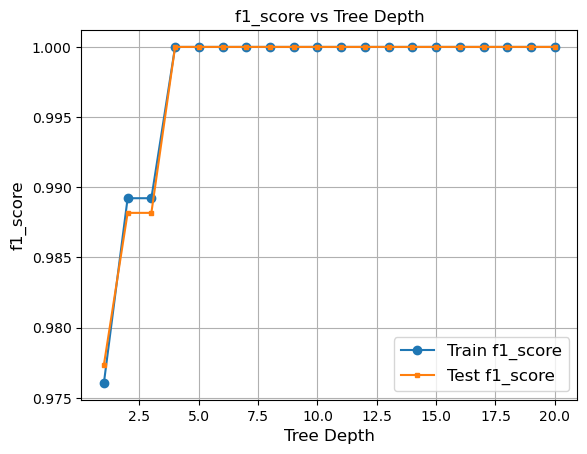

In [107]:
# Фиксируем параметры для контроля глубины дерева
max_depth_range = range(1, 21)  # Глубина от 1 до 20
train_scores = []
test_scores = []

# Перебор значений max_depth
for max_depth in max_depth_range:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Оценка на тренировочной и тестовой выборках
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_scores.append(f1_score(y_train, y_train_pred))
    test_scores.append(f1_score(y_test, y_test_pred))

# Построение графиков
plt.plot(max_depth_range, train_scores, label='Train f1_score', marker='o')
plt.plot(max_depth_range, test_scores, label='Test f1_score', marker='s',  markersize=3)

plt.xlabel('Tree Depth', fontsize=12)
plt.ylabel('f1_score', fontsize=12)
plt.title('f1_score vs Tree Depth')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='best', frameon=True)
plt.grid()
plt.show()

### Собственная реализации дерева принятия решений

In [111]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeClassifierCustom:
    def __init__(self, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, max_depth=None, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None
        self.current_leaf_count = 0

    def fit(self, X, y):
        self.current_leaf_count = 0
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(set(y))

        # Условия остановки
        if (
            num_samples < self.min_samples_split or
            num_classes == 1 or
            (self.max_depth is not None and depth >= self.max_depth) or
            (self.max_leaf_nodes is not None and self.current_leaf_count >= self.max_leaf_nodes)
        ):
            self.current_leaf_count += 1
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

        # Поиск лучшего разбиения
        best_feature, best_threshold, best_gain = None, None, -float("inf")
        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature_idx], threshold)
                if gain > best_gain:
                    best_feature, best_threshold, best_gain = feature_idx, threshold, gain

        # Если нет улучшений
        if best_gain == -float("inf"):
            self.current_leaf_count += 1
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

        # Разделение данных
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        # Проверка минимального размера листа
        if sum(left_indices) < self.min_samples_leaf or sum(right_indices) < self.min_samples_leaf:
            self.current_leaf_count += 1
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _gini(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _entropy(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))

    def _information_gain(self, y, feature_values, threshold):
        parent_loss = self._gini(y) if self.criterion == "gini" else self._entropy(y)
        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold

        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        left_loss = self._gini(y[left_indices]) if self.criterion == "gini" else self._entropy(y[left_indices])
        right_loss = self._gini(y[right_indices]) if self.criterion == "gini" else self._entropy(y[right_indices])

        child_loss = (len(y[left_indices]) / len(y)) * left_loss + (len(y[right_indices]) / len(y)) * right_loss
        return parent_loss - child_loss

    def predict(self, X):
        return np.array([self._predict_one(row, self.tree) for row in X])

    def _predict_one(self, row, node):
        if node.value is not None:
            return node.value
        if row[node.feature] <= node.threshold:
            return self._predict_one(row, node.left)
        else:
            return self._predict_one(row, node.right)

    def get_depth(self):
        return self._get_depth(self.tree)

    def _get_depth(self, node):
        if node is None or node.value is not None:
            return 0
        return 1 + max(self._get_depth(node.left), self._get_depth(node.right))

In [112]:
# Перебор значений гиперпараметров
param_grid = {
    'min_samples_split': [2, 5, 10, 20, 50], #Количество образцов, которые должны быть в узле для того, чтобы дерево могло его разделить
    'min_samples_leaf': [1, 2, 5, 10, 20, 50], #Устанавливает минимальное количество образцов в каждом листе дерева
    'max_leaf_nodes': [2, 3, 4, 10, 25, 50, 100] #Ограничивает максимальное количество листьев в дереве
}

# Сохраним результаты
results = []
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

for min_samples_split in param_grid['min_samples_split']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
        for max_leaf_nodes in param_grid['max_leaf_nodes']:
            model = DecisionTreeClassifierCustom(
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_leaf_nodes=max_leaf_nodes, criterion='gini'
            )
            model.fit(X_train_np, y_train_np)
            tree_depth = model.get_depth()

            # Прогнозы на тренировочных и тестовых данных
            train_preds = model.predict(X_train_np)
            test_preds = model.predict(X_test_np)

            # Вычисление F1-Score для тренировки и теста
            train_f1 = f1_score(y_train_np, train_preds)
            test_f1 = f1_score(y_test_np, test_preds)

            # Сохранение метрик и глубины
            
            results.append({
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'tree_depth': tree_depth,
                'train_f1': train_f1,
                'test_f1': test_f1
            })

In [113]:
results_df_base = pd.DataFrame(results)
print("Уникальные значения глубины дерева:", results_df_base['tree_depth'].unique())
print("Уникальные значения метрик качества на тренировочной выборке:", results_df_base['train_f1'].unique())
print("Уникальные значения метрик качества на тестовой выборке:", results_df_base['test_f1'].unique())

Уникальные значения глубины дерева: [4 1]
Уникальные значения метрик качества на тренировочной выборке: [1.         0.97606048]
Уникальные значения метрик качества на тестовой выборке: [1.         0.97735849]


#### График зависимости высоты полученного дерева

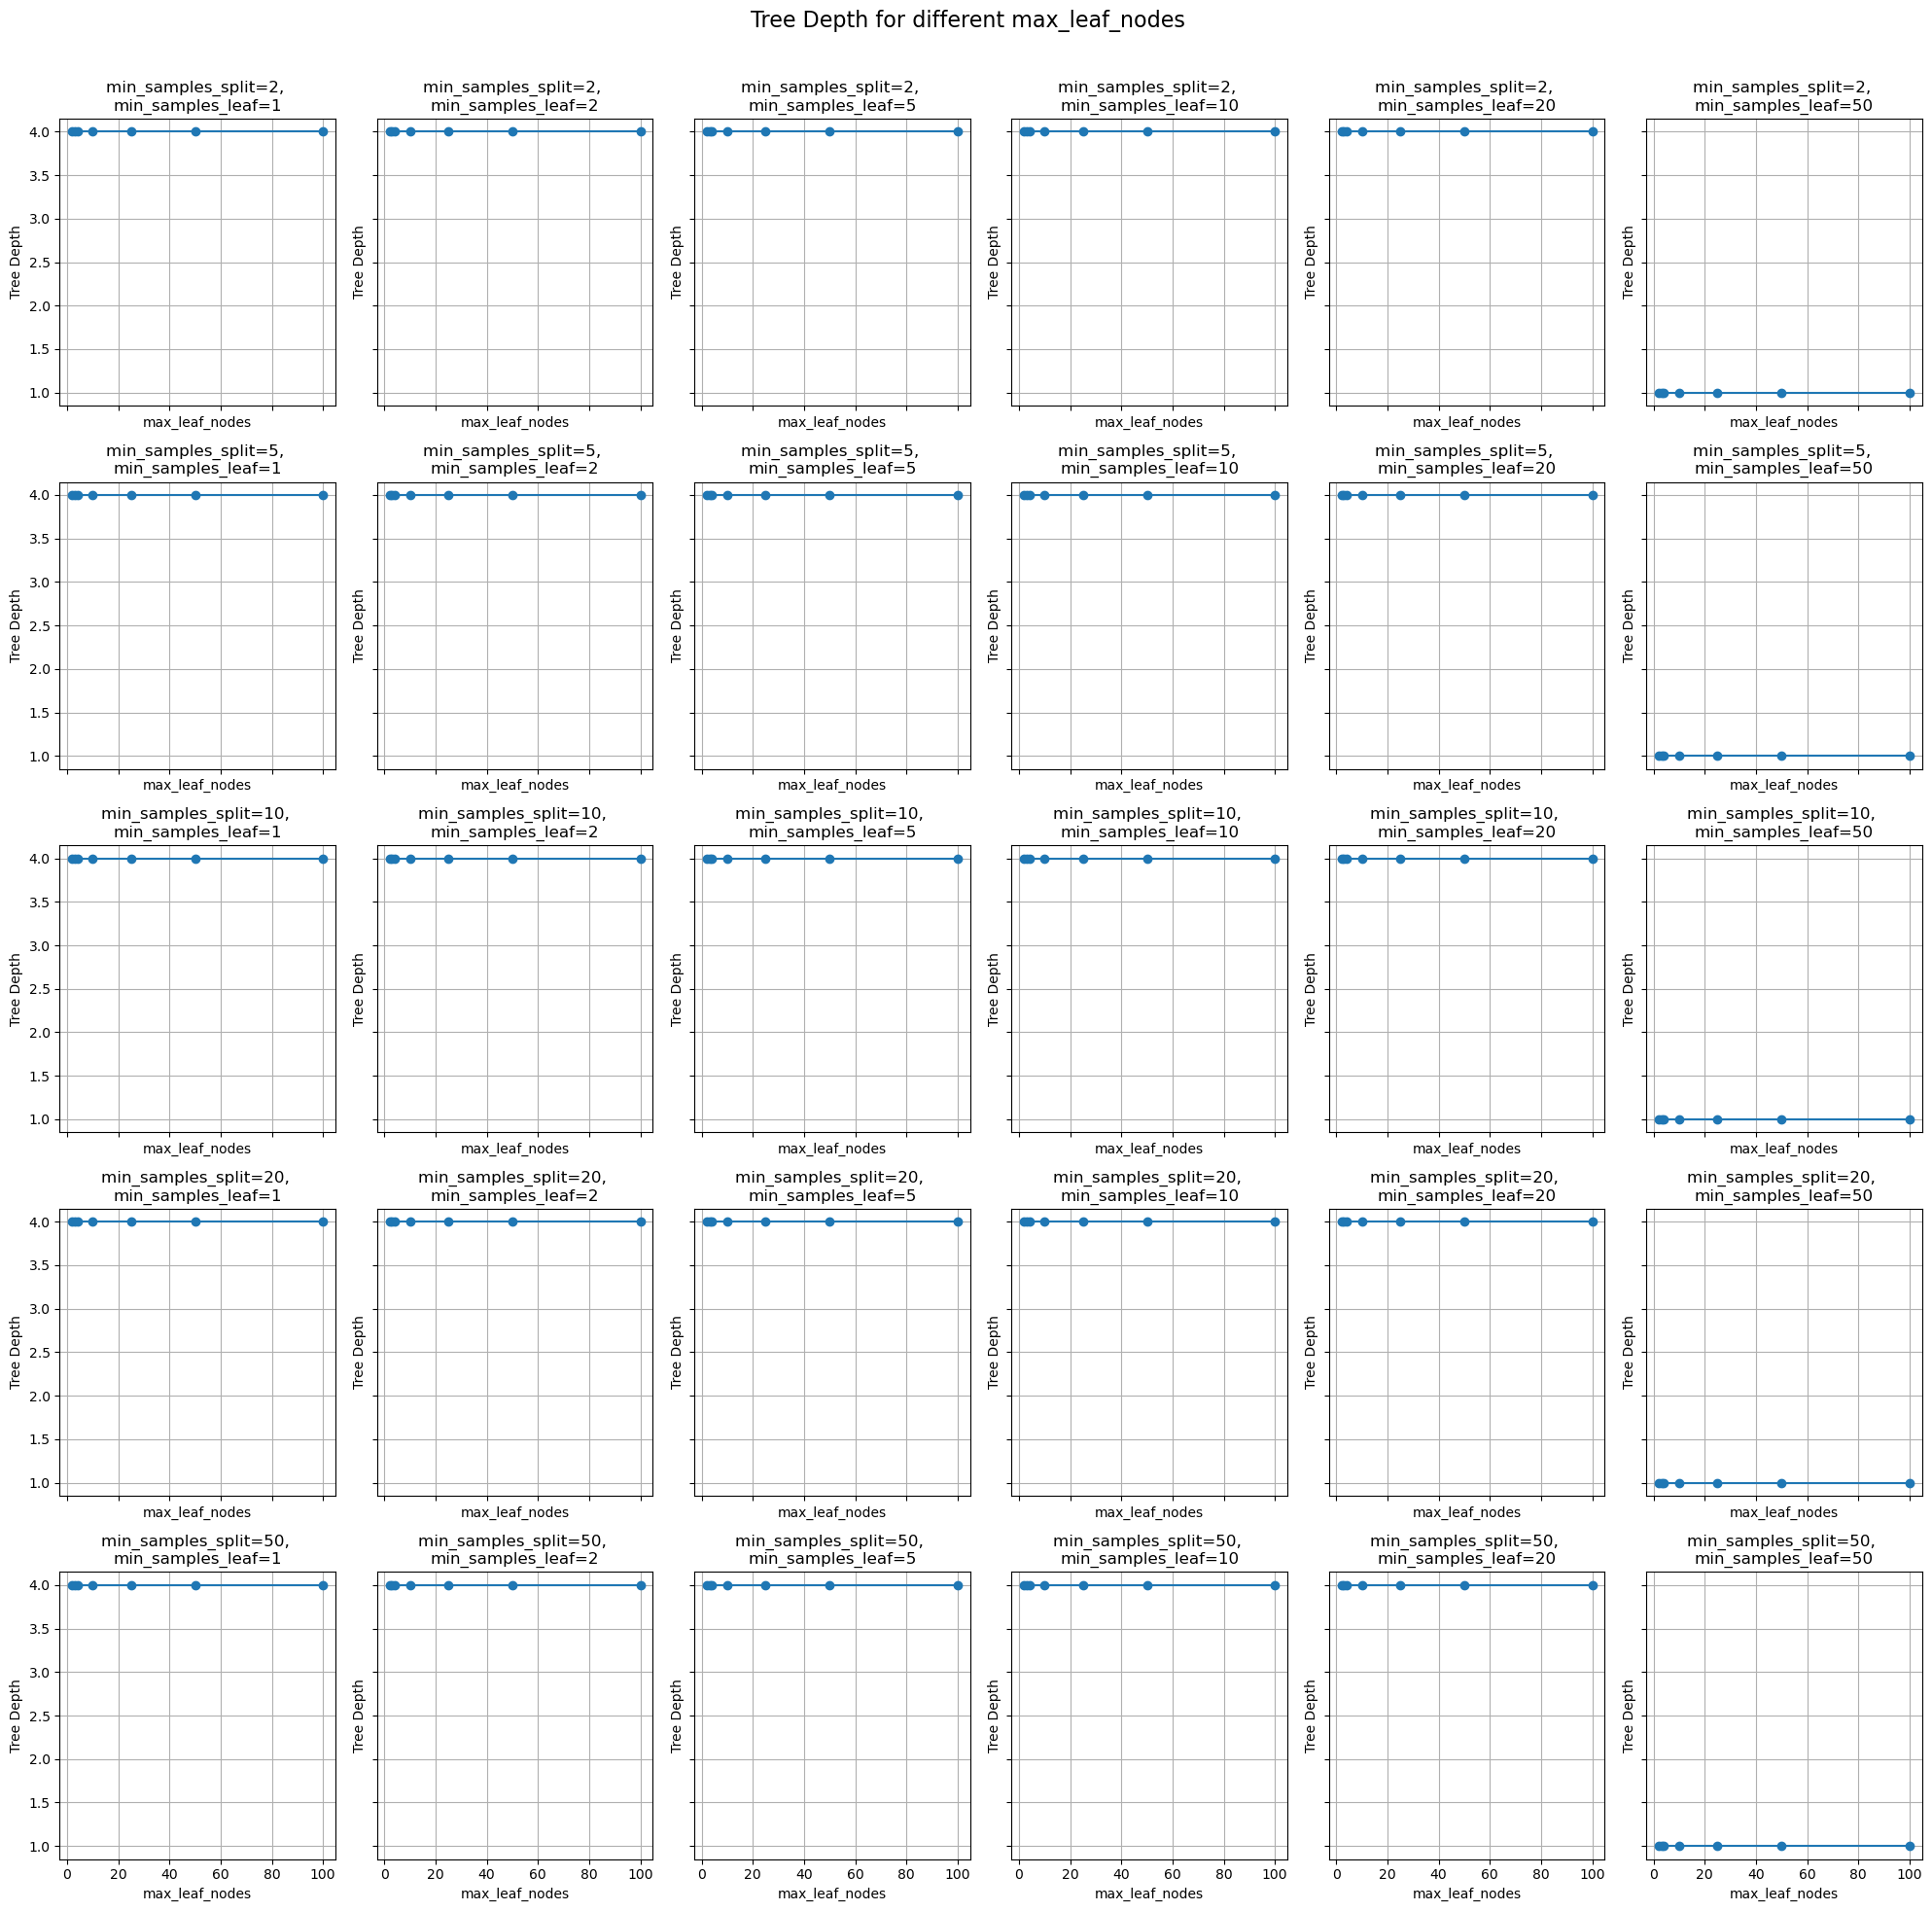

In [115]:
# Сохраним результаты
results = []
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Перебираем все комбинации двух фиксированных параметров
varied_param = 'max_leaf_nodes'
fixed_params_keys = [key for key in param_grid.keys() if key != varied_param]

# Построение графиков
fig, axes = plt.subplots(
    len(param_grid[fixed_params_keys[0]]),
    len(param_grid[fixed_params_keys[1]]),
    figsize=(20, 20),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, fixed_param_1_value in enumerate(param_grid[fixed_params_keys[0]]):
    for j, fixed_param_2_value in enumerate(param_grid[fixed_params_keys[1]]):
        # Индекс текущего графика
        ax = axes[i * len(param_grid[fixed_params_keys[1]]) + j]

        # Результаты для текущей комбинации
        results = []

        for value in param_grid[varied_param]:
            model = DecisionTreeClassifierCustom(
                **{fixed_params_keys[0]: fixed_param_1_value, fixed_params_keys[1]: fixed_param_2_value},
                **{varied_param: value}, 
                criterion='gini'
            )
            model.fit(X_train_np, y_train_np)
            tree_depth = model.get_depth()

            # Прогнозы на тренировочных и тестовых данных
            train_preds = model.predict(X_train_np)
            test_preds = model.predict(X_test_np)

            # Вычисление F1-Score для тренировки и теста
            train_f1 = f1_score(y_train_np, train_preds)
            test_f1 = f1_score(y_test_np, test_preds)

            # Сохранение метрик и глубины
            
            results.append({'varied_param_value': value, 'tree_depth': tree_depth})

        # Преобразование в DataFrame
        results_df = pd.DataFrame(results)

        # Построение графика
        ax.plot(results_df['varied_param_value'], results_df['tree_depth'], marker='o')
        ax.set_title(f"{fixed_params_keys[0]}={fixed_param_1_value}, \n{fixed_params_keys[1]}={fixed_param_2_value}")
        ax.set_xlabel(varied_param)
        ax.set_ylabel('Tree Depth')
        ax.grid(True)

# Общий заголовок
plt.suptitle("Tree Depth for different max_leaf_nodes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

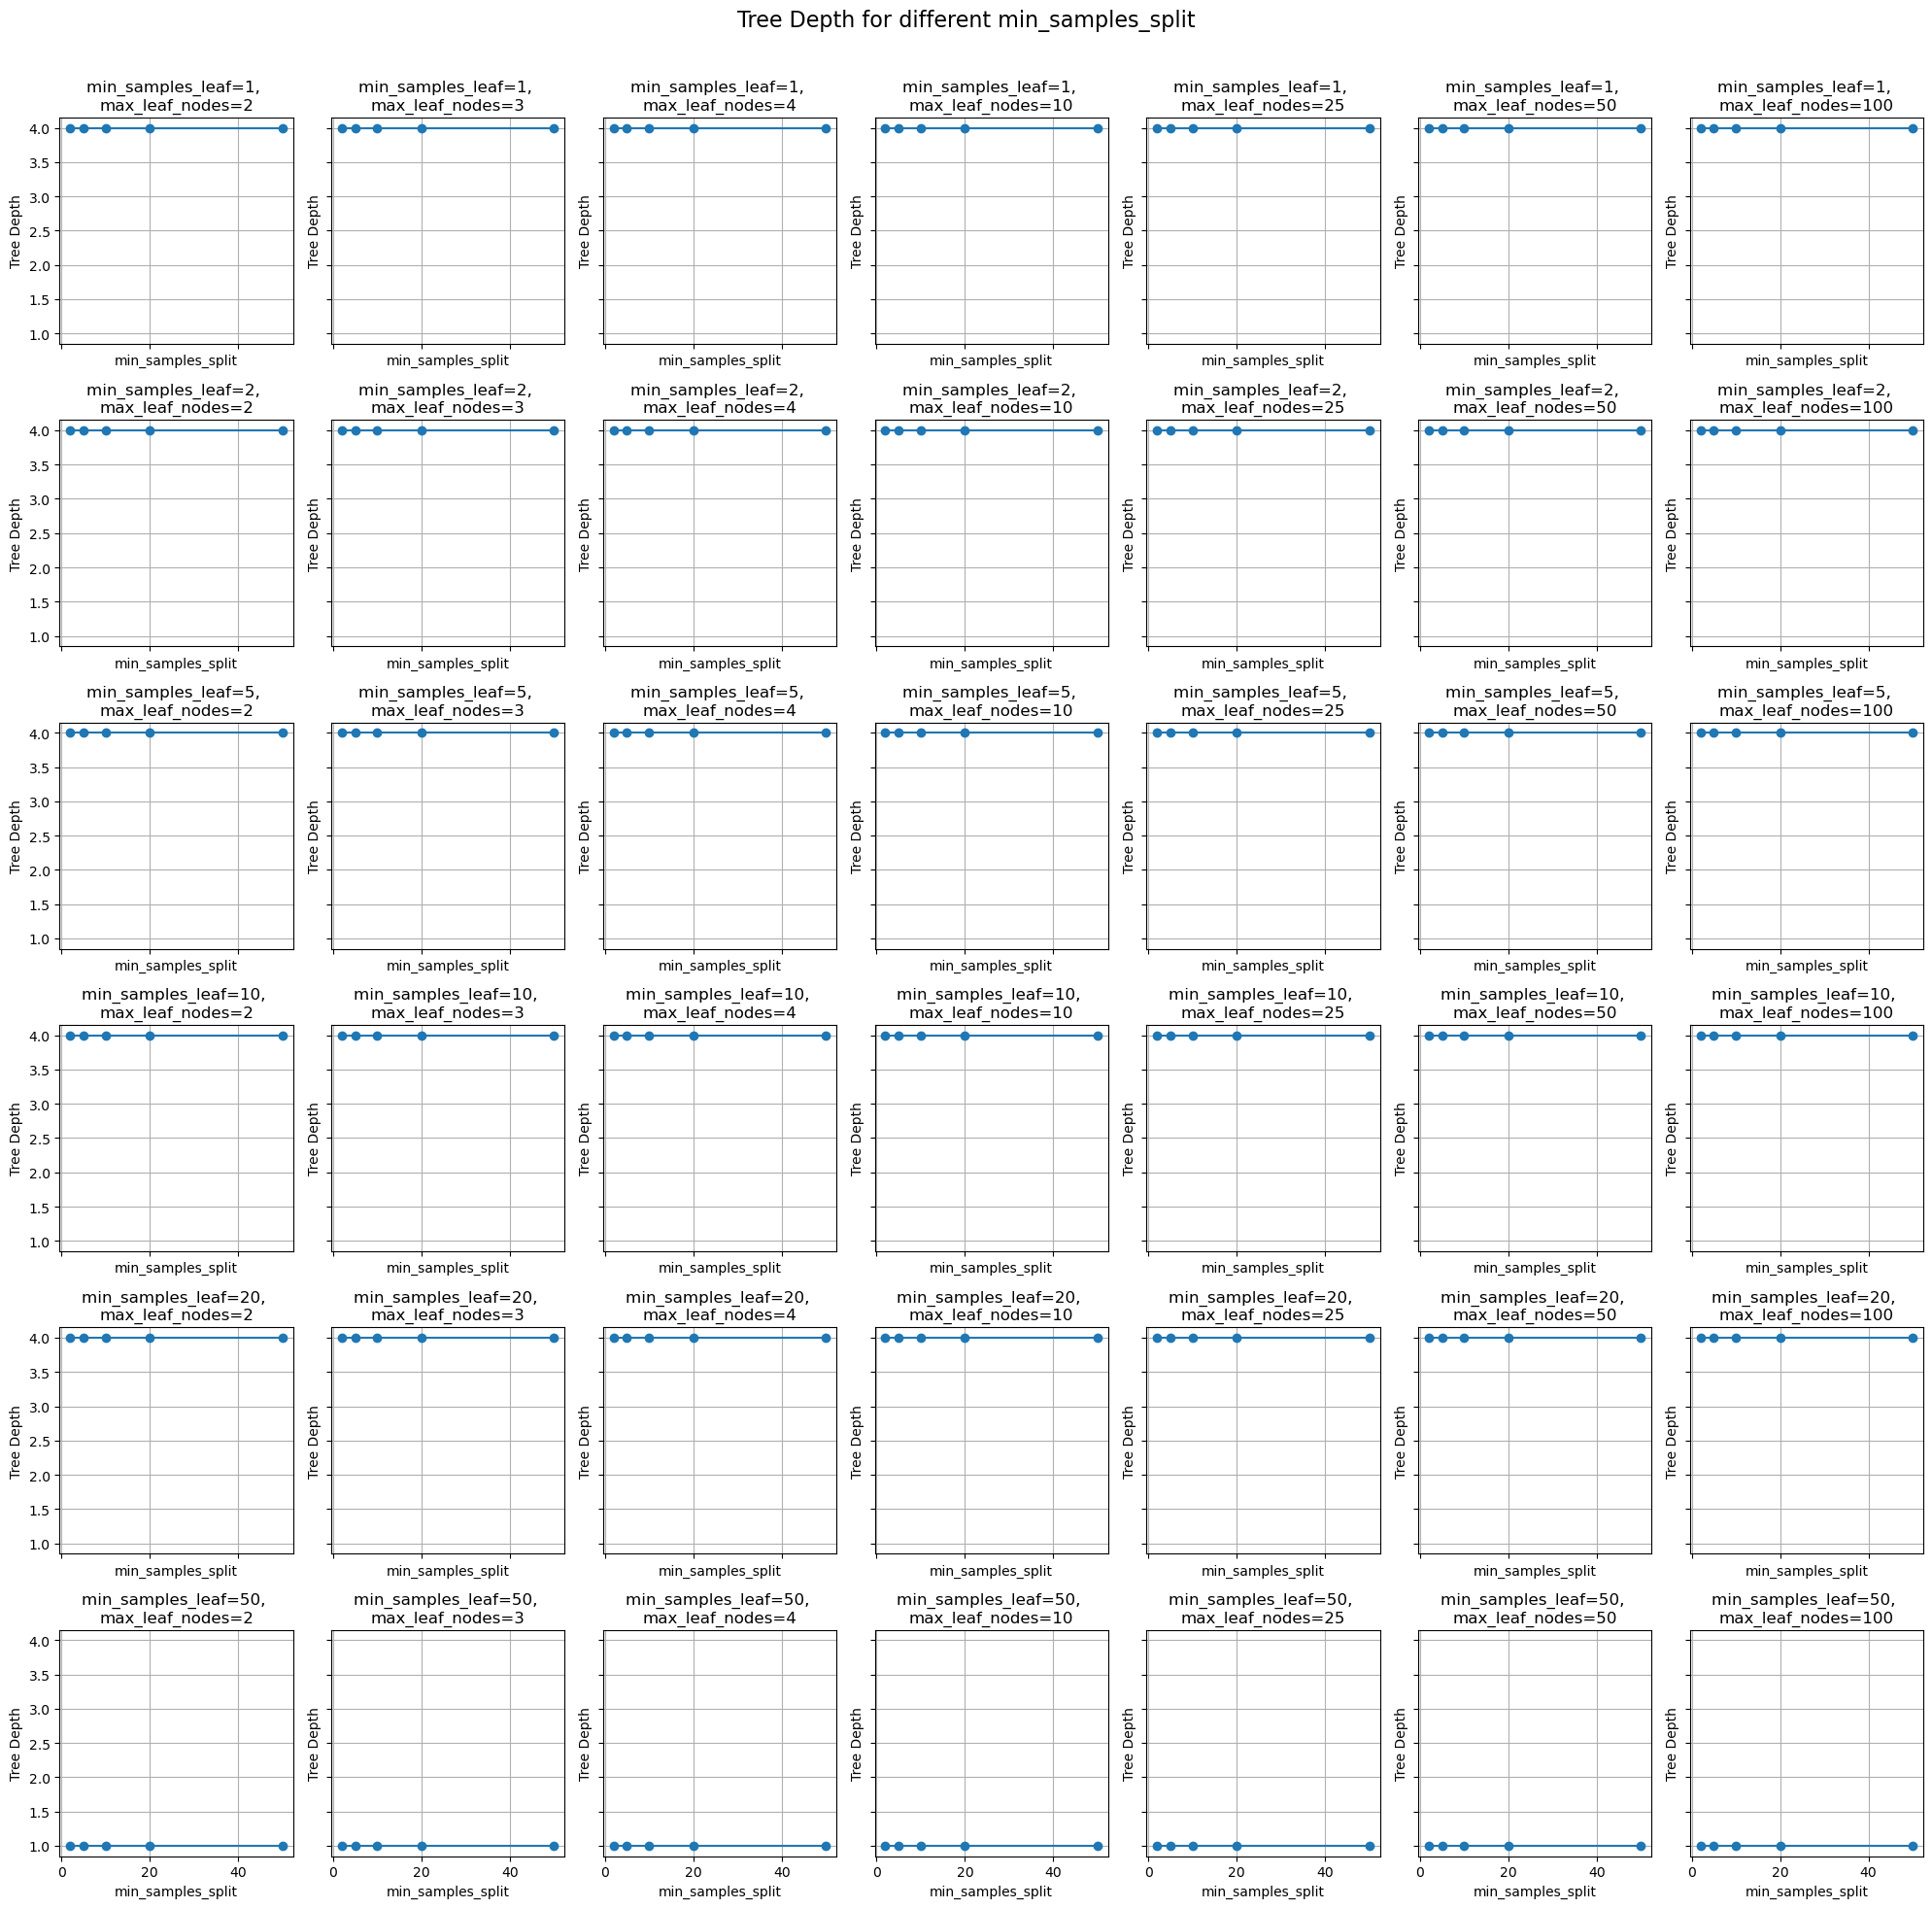

In [116]:
# Сохраним результаты
results = []
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Перебираем все комбинации двух фиксированных параметров
varied_param = 'min_samples_split'
fixed_params_keys = [key for key in param_grid.keys() if key != varied_param]

# Построение графиков
fig, axes = plt.subplots(
    len(param_grid[fixed_params_keys[0]]),
    len(param_grid[fixed_params_keys[1]]),
    figsize=(20, 20),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, fixed_param_1_value in enumerate(param_grid[fixed_params_keys[0]]):
    for j, fixed_param_2_value in enumerate(param_grid[fixed_params_keys[1]]):
        # Индекс текущего графика
        ax = axes[i * len(param_grid[fixed_params_keys[1]]) + j]

        # Результаты для текущей комбинации
        results = []

        for value in param_grid[varied_param]:
            model = DecisionTreeClassifierCustom(
                **{fixed_params_keys[0]: fixed_param_1_value, fixed_params_keys[1]: fixed_param_2_value},
                **{varied_param: value}, 
                criterion='gini'
            )
            model.fit(X_train_np, y_train_np)
            tree_depth = model.get_depth()

            # Прогнозы на тренировочных и тестовых данных
            train_preds = model.predict(X_train_np)
            test_preds = model.predict(X_test_np)

            # Вычисление F1-Score для тренировки и теста
            train_f1 = f1_score(y_train_np, train_preds)
            test_f1 = f1_score(y_test_np, test_preds)

            # Сохранение метрик и глубины
            
            results.append({'varied_param_value': value, 'tree_depth': tree_depth})

        # Преобразование в DataFrame
        results_df = pd.DataFrame(results)

        # Построение графика
        ax.plot(results_df['varied_param_value'], results_df['tree_depth'], marker='o')
        ax.set_title(f"{fixed_params_keys[0]}={fixed_param_1_value}, \n{fixed_params_keys[1]}={fixed_param_2_value}")
        ax.set_xlabel(varied_param)
        ax.set_ylabel('Tree Depth')
        ax.grid(True)

# Общий заголовок
plt.suptitle("Tree Depth for different min_samples_split", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

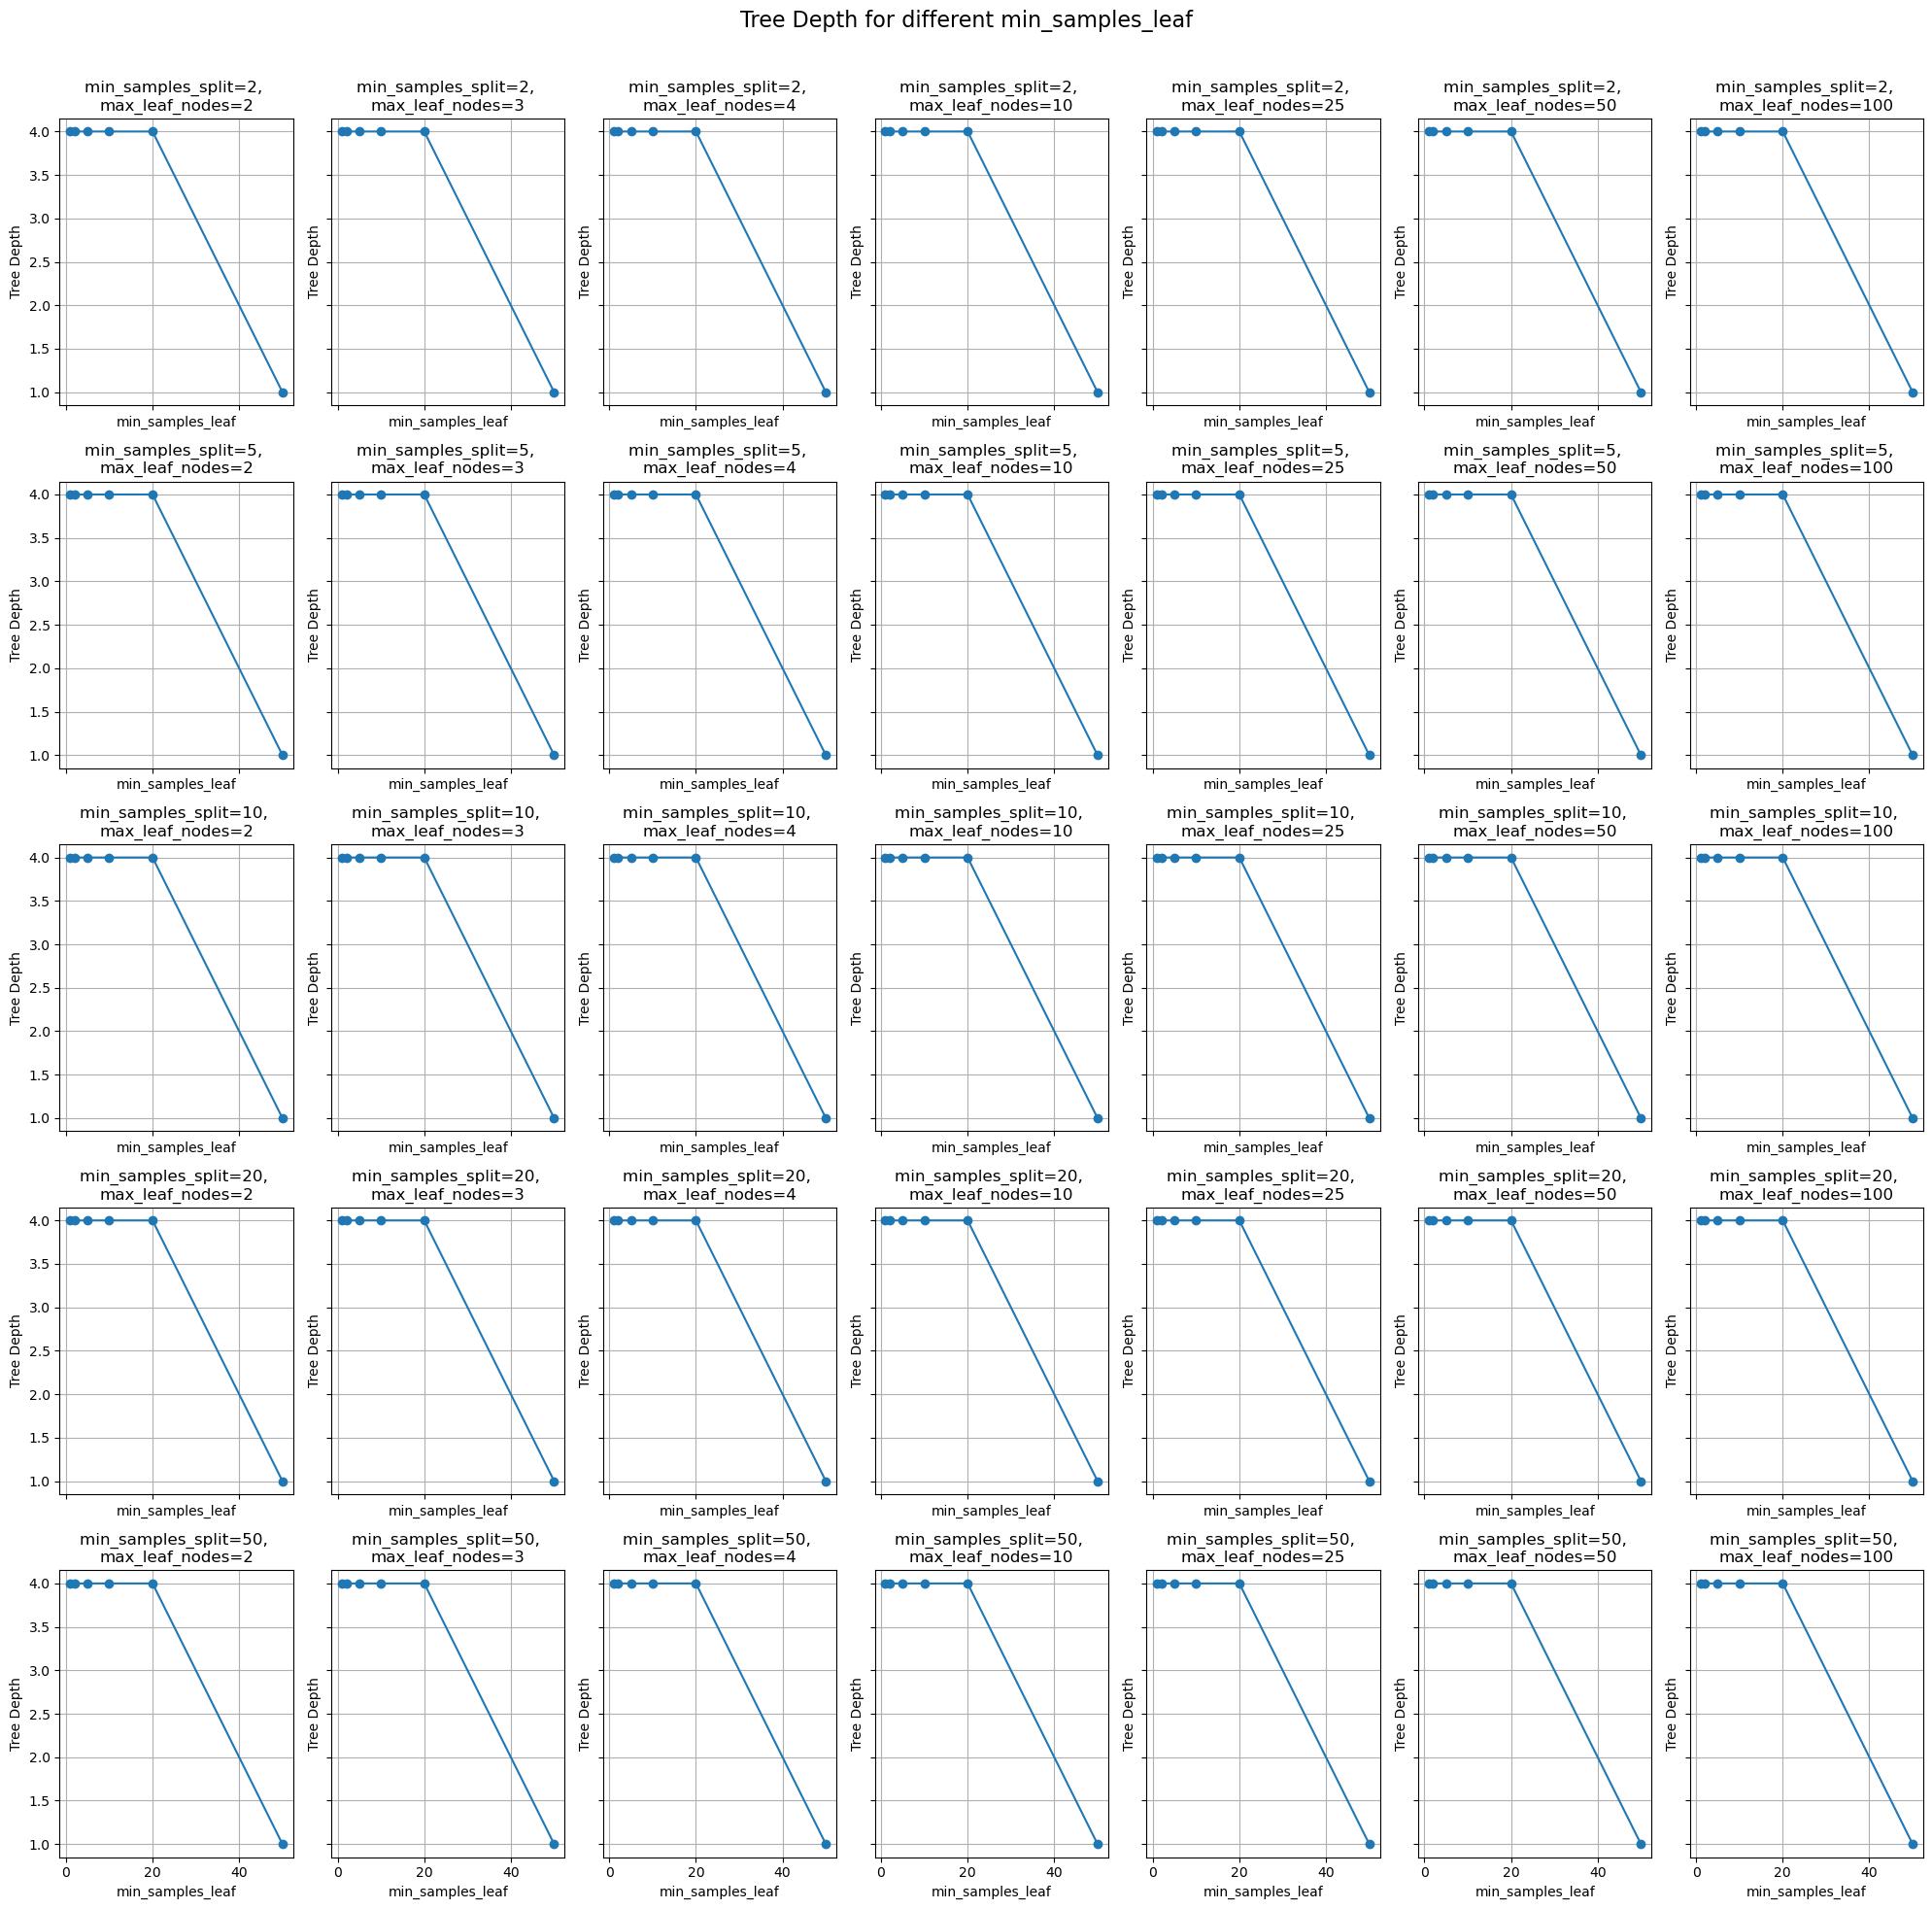

In [117]:
# Сохраним результаты
results = []
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Перебираем все комбинации двух фиксированных параметров
varied_param = 'min_samples_leaf'
fixed_params_keys = [key for key in param_grid.keys() if key != varied_param]

# Построение графиков
fig, axes = plt.subplots(
    len(param_grid[fixed_params_keys[0]]),
    len(param_grid[fixed_params_keys[1]]),
    figsize=(20, 20),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, fixed_param_1_value in enumerate(param_grid[fixed_params_keys[0]]):
    for j, fixed_param_2_value in enumerate(param_grid[fixed_params_keys[1]]):
        # Индекс текущего графика
        ax = axes[i * len(param_grid[fixed_params_keys[1]]) + j]

        # Результаты для текущей комбинации
        results = []

        for value in param_grid[varied_param]:
            model = DecisionTreeClassifierCustom(
                **{fixed_params_keys[0]: fixed_param_1_value, fixed_params_keys[1]: fixed_param_2_value},
                **{varied_param: value}, 
                criterion='gini'
            )
            model.fit(X_train_np, y_train_np)
            tree_depth = model.get_depth()

            # Прогнозы на тренировочных и тестовых данных
            train_preds = model.predict(X_train_np)
            test_preds = model.predict(X_test_np)

            # Вычисление F1-Score для тренировки и теста
            train_f1 = f1_score(y_train_np, train_preds)
            test_f1 = f1_score(y_test_np, test_preds)

            # Сохранение метрик и глубины
            
            results.append({'varied_param_value': value, 'tree_depth': tree_depth})

        # Преобразование в DataFrame
        results_df = pd.DataFrame(results)

        # Построение графика
        ax.plot(results_df['varied_param_value'], results_df['tree_depth'], marker='o')
        ax.set_title(f"{fixed_params_keys[0]}={fixed_param_1_value}, \n{fixed_params_keys[1]}={fixed_param_2_value}")
        ax.set_xlabel(varied_param)
        ax.set_ylabel('Tree Depth')
        ax.grid(True)

# Общий заголовок
plt.suptitle("Tree Depth for different min_samples_leaf", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

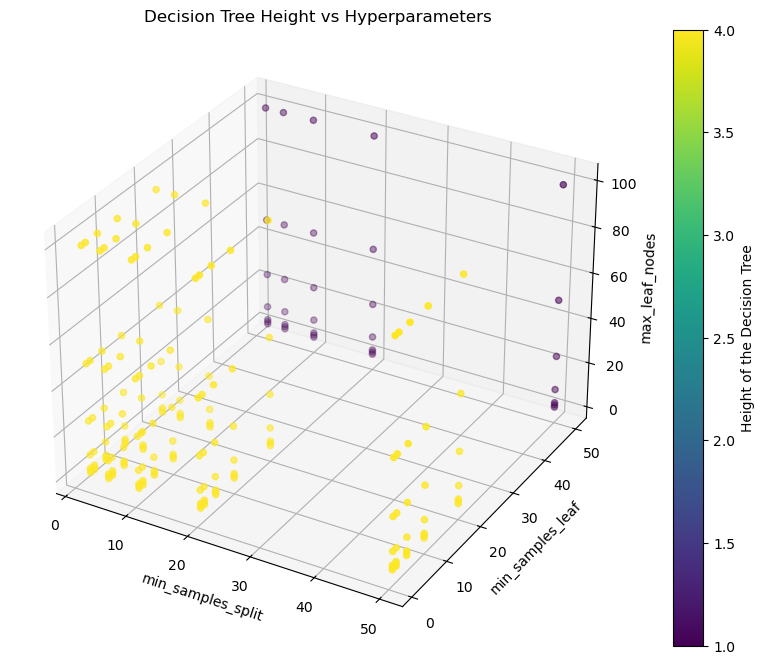

In [118]:
# Визуализация
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Проход по данным и построение точек
sc = ax.scatter(results_df_base['min_samples_split'], results_df_base['min_samples_leaf'], results_df_base['max_leaf_nodes'],
                c=results_df_base['tree_depth'], cmap='viridis')

# Настройки графика
ax.set_xlabel('min_samples_split')
ax.set_ylabel('min_samples_leaf')
ax.set_zlabel('max_leaf_nodes')
ax.set_title('Decision Tree Height vs Hyperparameters')
plt.colorbar(sc, label='Height of the Decision Tree')  # добавление цветовой шкалы
plt.grid()
plt.show()

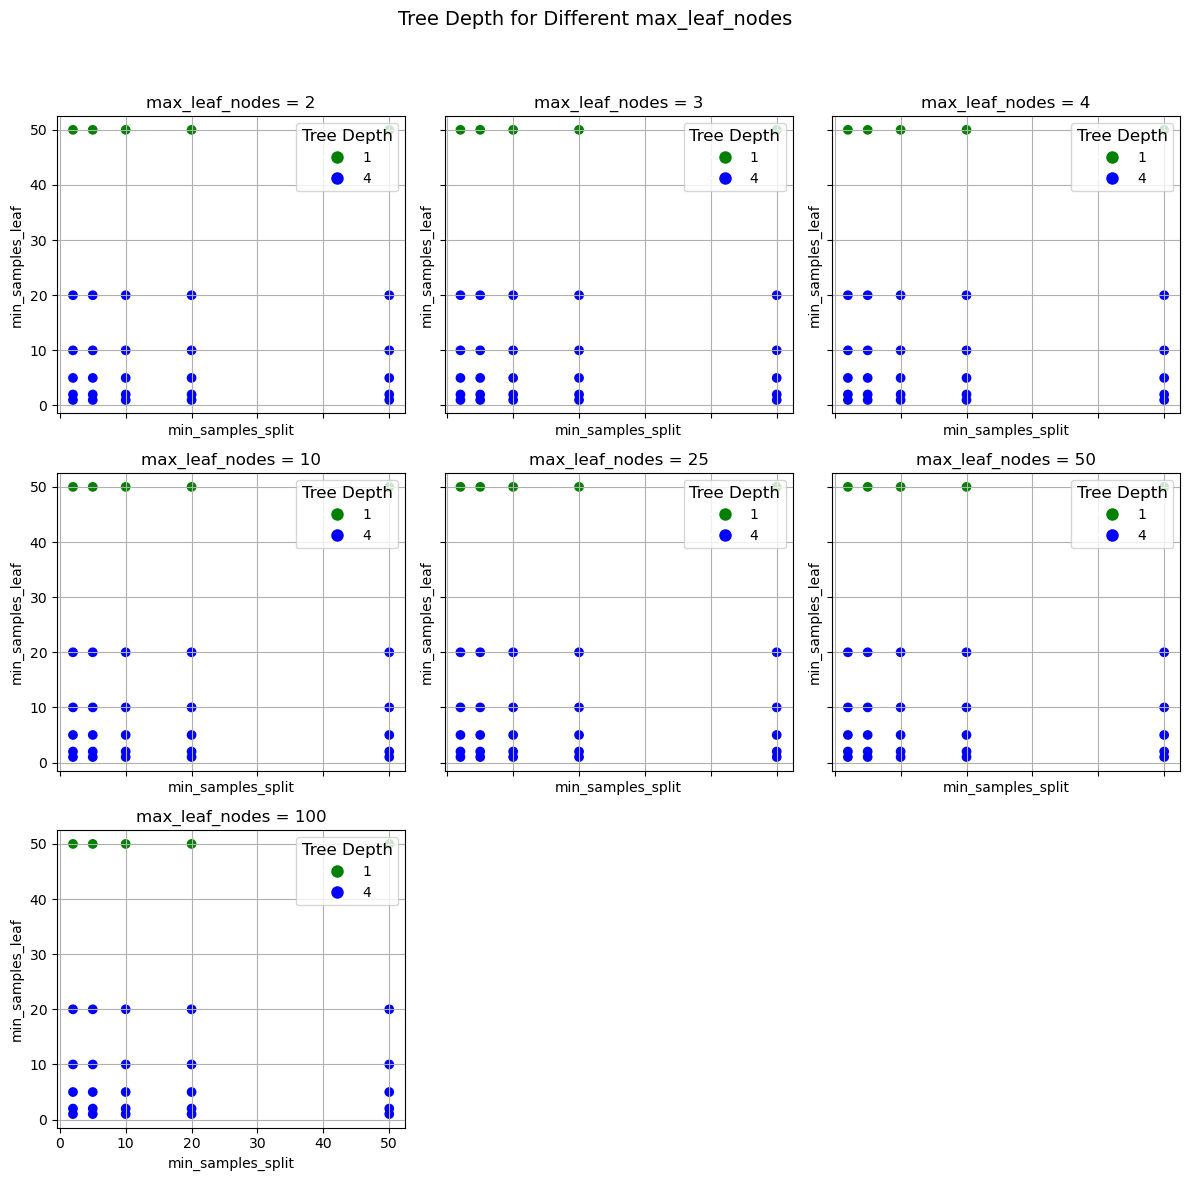

In [119]:
unique_max_leaf_nodes = results_df_base['max_leaf_nodes'].unique()

# Определяем количество строк и столбцов для компоновки графиков
ncols = 3  # Количество графиков в одной строке
nrows = (len(unique_max_leaf_nodes) + ncols - 1) // ncols  # Рассчитываем количество строк

# Дискретная цветовая палитра для tree_depth
colors = ['green', 'blue']
cmap = mcolors.ListedColormap(colors)

# Нормализация значений на 4 дискретных интервала
bounds = list(np.unique(results_df_base['tree_depth'])) + [results_df_base['tree_depth'].max() + 1]  # Интервалы для tree_depth
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Визуализация 2D-графиков для каждого значения max_leaf_nodes
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 4 * nrows),
    sharex=True,
    sharey=True
)

axes = axes.flatten()  # Превращаем массив осей в плоский список

for i, max_leaf_nodes in enumerate(unique_max_leaf_nodes):
    subset = results_df_base[results_df_base['max_leaf_nodes'] == max_leaf_nodes]
    ax = axes[i]
    
    # Рисуем точки с дискретными цветами
    sc = ax.scatter(
        subset['min_samples_split'], 
        subset['min_samples_leaf'], 
        c=subset['tree_depth'], 
        cmap=cmap, 
        norm=norm
    )
    ax.set_title(f'max_leaf_nodes = {max_leaf_nodes}')
    ax.set_xlabel('min_samples_split')
    ax.set_ylabel('min_samples_leaf')
    ax.grid(True)

    # Добавление легенды с точками
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [*sorted(results_df_base['tree_depth'].unique())]
    ax.legend(handles=handles, labels=labels, title='Tree Depth', loc='upper right', fontsize=10,  title_fontsize=12)

# Убираем лишние оси (если графиков меньше, чем ячеек в сетке)
for j in range(len(unique_max_leaf_nodes), len(axes)):
    fig.delaxes(axes[j])

# Добавление общей легенды
plt.suptitle('Tree Depth for Different max_leaf_nodes', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### График зависимости функции качества от высоты дерева 

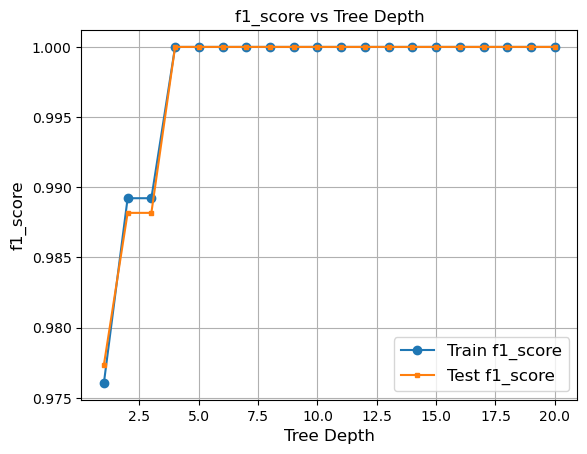

In [121]:
# Фиксируем параметры для контроля глубины дерева
max_depth_range = range(1, 21)  # Глубина от 1 до 20
train_scores = []
test_scores = []

# Перебор значений max_depth
for max_depth in max_depth_range:
    model = DecisionTreeClassifierCustom(max_depth=max_depth)
    model.fit(X_train_np, y_train_np)

    # Оценка на тренировочной и тестовой выборках
    y_train_pred = model.predict(X_train_np)
    y_test_pred = model.predict(X_test_np)

    train_scores.append(f1_score(y_train_np, y_train_pred))
    test_scores.append(f1_score(y_test_np, y_test_pred))

# Построение графиков
plt.plot(max_depth_range, train_scores, label='Train f1_score', marker='o')
plt.plot(max_depth_range, test_scores, label='Test f1_score', marker='s', markersize=3)

plt.xlabel('Tree Depth', fontsize=12)
plt.ylabel('f1_score', fontsize=12)
plt.title('f1_score vs Tree Depth')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='best', frameon=True)
plt.grid()
plt.show()


### 2) Алгоритм случайного леса

### Библиотечная реализация алгоритма случайного леса

In [124]:
# Разделим данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2437, 34) (2437,)
(1626, 34) (1626,)


#### График зависимости функции качества от числа деревьев 

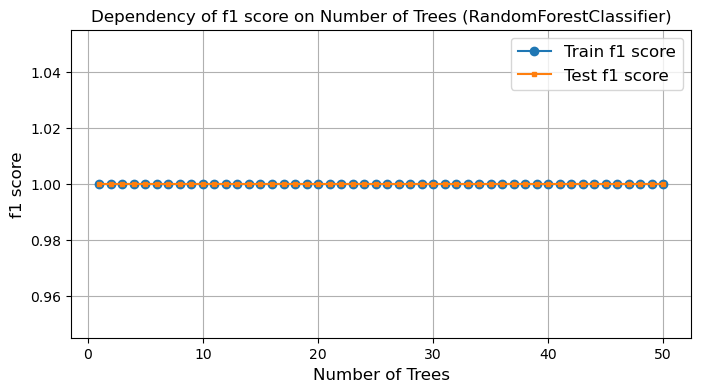

In [126]:
# Параметры эксперимента
max_trees = 50  # Число деревьев
train_scores = []
test_scores = []

# Обучение моделей
for i in range(1, max_trees+1):
    model = RandomForestClassifier(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    
    # Метрики
    train_scores.append(f1_score(y_train, model.predict(X_train)))
    test_scores.append(f1_score(y_test, model.predict(X_test)))

# Построение графиков
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_trees + 1), train_scores, label='Train f1 score', marker='o')
plt.plot(range(1, max_trees + 1), test_scores, label='Test f1 score', marker='s',  markersize=3)

plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('f1 score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dependency of f1 score on Number of Trees (RandomForestClassifier)')
plt.legend(fontsize=12, loc='best', frameon=True)
plt.grid(True)
plt.show()

### Собственная реализации алгоритма случайного леса

In [129]:
# Разделим данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2437, 34) (2437,)
(1626, 34) (1626,)


In [130]:
class RandomForestClassifierCustom:
    def __init__(self, n_estimators=100, max_features='auto', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, criterion='gini', random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        self.criterion = criterion
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []
        
        for _ in range(self.n_estimators):
            # Случайная выборка с заменой (bootstrap sampling)
            X_resampled, y_resampled = resample(X, y, random_state=self.random_state)
            tree = DecisionTreeClassifierCustom(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_leaf_nodes=self.max_leaf_nodes,
                criterion=self.criterion
            )
            tree.fit(X_resampled, y_resampled)
            self.trees.append(tree)

    def predict(self, X):
        # Предсказание для каждого дерева
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Голосование по всем деревьям
        return [Counter(pred).most_common(1)[0][0] for pred in predictions.T]

    def predict_proba(self, X):
        # Вероятности для каждого дерева
        probas = np.array([tree.predict_proba(X) for tree in self.trees])
        # Усреднение вероятностей по деревьям
        return np.mean(probas, axis=0)

    def get_depth(self):
        return max(tree.get_depth() for tree in self.trees)

#### График зависимости функции качества от числа деревьев

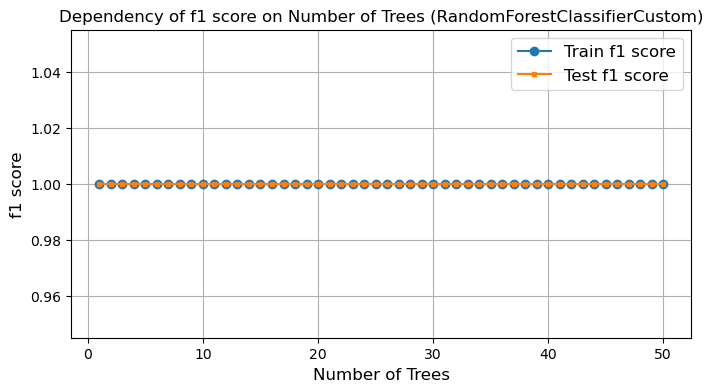

In [132]:
# Параметры эксперимента
max_trees = 50  # Число деревьев
train_scores = []
test_scores = []

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Обучение моделей
for i in range(1, max_trees+1):
    model = RandomForestClassifierCustom(n_estimators=i, random_state=42)
    model.fit(X_train_np, y_train_np)
    
    # Метрики
    train_scores.append(f1_score(y_train_np, model.predict(X_train_np)))
    test_scores.append(f1_score(y_test_np, model.predict(X_test_np)))

# Построение графиков
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_trees + 1), train_scores, label='Train f1 score', marker='o')
plt.plot(range(1, max_trees + 1), test_scores, label='Test f1 score', marker='s',  markersize=3)

plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('f1 score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dependency of f1 score on Number of Trees (RandomForestClassifierCustom)')
plt.legend(fontsize=12, loc='best', frameon=True)
plt.grid(True)
plt.show()

### 3) Алгоритм бустинга

### Библиотечная реализация алгоритма бустинга

In [136]:
# Разделим данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2437, 34) (2437,)
(1626, 34) (1626,)


#### График зависимости функции качества от числа деревьев

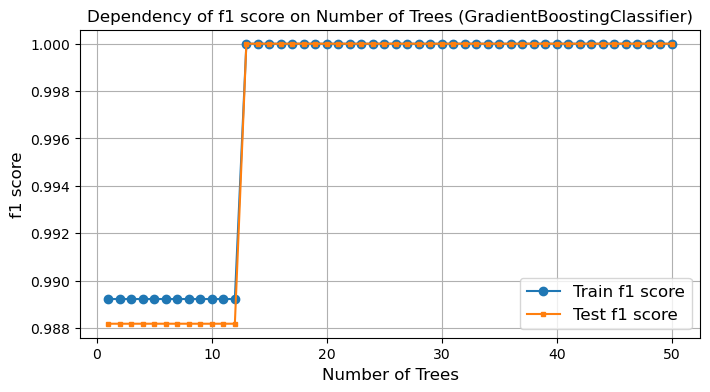

In [139]:
# Гиперпараметры
max_trees = 50
train_scores, test_scores = [], []

for i in range(1, max_trees+1):
    model = GradientBoostingClassifier(n_estimators=i, warm_start=True, random_state=42).fit(X_train, y_train)

    # Метрики
    train_scores.append(f1_score(y_train, model.predict(X_train)))
    test_scores.append(f1_score(y_test, model.predict(X_test)))

# Построение графиков
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_trees + 1), train_scores, label='Train f1 score', marker='o')
plt.plot(range(1, max_trees + 1), test_scores, label='Test f1 score', marker='s', markersize=3)

plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('f1 score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dependency of f1 score on Number of Trees (GradientBoostingClassifier)')
plt.legend(fontsize=12, loc='best', frameon=True)
plt.grid(True)
plt.show()

### Собственная реализации алгоритма бустинга

In [219]:
# Разделим данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1337)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

X_test_np, X_valid_np, y_test_np, y_valid_np = train_test_split(X_test_np, y_test_np, test_size=0.5, random_state=1337)

X_train_np.shape, X_valid_np.shape, X_test_np.shape

((2437, 34), (813, 34), (813, 34))

In [241]:
sns.set(style='darkgrid')

def score(clf, x, y):
    predictions = clf.predict_proba(x)[:, 1] > 0.5  # Конвертация вероятностей в бинарные метки
    return f1_score(y, predictions)

class BoostingCustom:
    def __init__(
        self,
        base_model_params: dict = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        subsample: float = 0.5,
        early_stopping_rounds: int = None,
        plot: bool = False,
    ):
        self.base_model_class = DecisionTreeClassifierCustom
        self.base_model_params = {} if base_model_params is None else base_model_params

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.early_stopping_rounds = early_stopping_rounds
        self.plot = plot

        self.models = []
        self.gammas = []
        self.history = defaultdict(list)
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()

    def fit_new_base_model(self, x_train, y_train, predictions, x_eval=None):
        # Случайная выборка
        n_samples = len(y_train)
        indices = np.random.choice(np.arange(n_samples), size=int(n_samples * self.subsample), replace=True)
        x_subsample = x_train[indices]
        y_subsample = y_train[indices]
    
        # Тренируем base_model
        model = self.base_model_class(**self.base_model_params)
        model.fit(x_subsample, y_subsample)
    
        # Получаем новые предсказания
        new_train_predictions = model.predict(x_train)
        
        # Получаем прогнозы для оценивания данных, если они предоставлены
        if x_eval is not None:
            new_eval_predictions = model.predict(x_eval)
        else:
            new_eval_predictions = None
    
        # Находим оптимальную гамму
        gamma = self.find_optimal_gamma(y_train, predictions, new_train_predictions)
    
        # Обновляем модель и гаммы
        self.models.append(model)
        self.gammas.append(gamma)
    
        return new_train_predictions, new_eval_predictions

    def fit(self, X_train, y_train, X_valid, y_valid):
        train_predictions = np.zeros(y_train.shape[0])
        valid_predictions = np.zeros(y_valid.shape[0])
    
        for i in range(self.n_estimators):
            # Тренируем новую base_model и получаем предсказания
            new_train_predictions, new_valid_predictions = self.fit_new_base_model(
                X_train, y_train, train_predictions, x_eval=X_valid
            )
    
            # Обновляем предсказания
            train_predictions += self.learning_rate * new_train_predictions
            valid_predictions += self.learning_rate * new_valid_predictions
    
            # Считаем потери для ранней остановки
            train_loss = self.loss_fn(y_train, train_predictions)
            valid_loss = self.loss_fn(y_valid, valid_predictions)
    
            self.history['train_loss'].append(train_loss)
            self.history['valid_loss'].append(valid_loss)
    
            if self.early_stopping_rounds:
                if i >= self.early_stopping_rounds and valid_loss > min(self.history['valid_loss'][-self.early_stopping_rounds:]):
                    # print(f"Early stopping at round {i}")
                    break
    
        if self.plot:
            self.plot_loss()
    
        return self

    def predict_proba(self, x):
        predictions = np.zeros(x.shape[0])
        for gamma, model in zip(self.gammas, self.models):
            predictions += gamma * model.predict(x)
        probabilities = self.sigmoid(predictions)
        return np.column_stack([1 - probabilities, probabilities])

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, x, y):
        return score(self, x, y)

    def plot_loss(self):
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['valid_loss'], label='Validation Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

#### График зависимости функции качества от числа деревьев

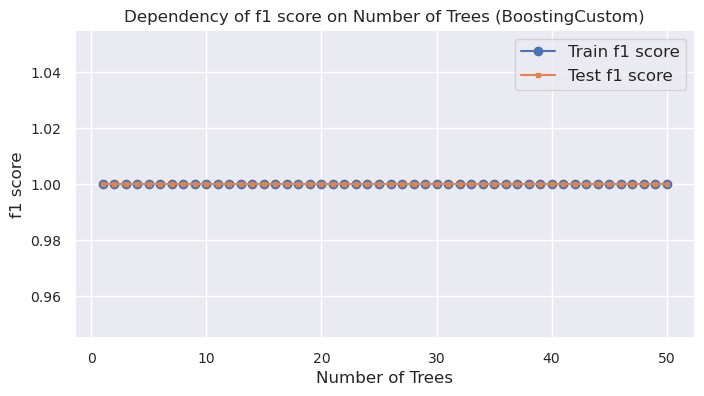

In [239]:
# Гиперпараметры
max_trees = 50
train_scores, test_scores = [], []

# Расчет метрик
for i in range(1, max_trees+1):
    model = BoostingCustom(n_estimators=i, early_stopping_rounds=5).fit(X_train_np, y_train_np, X_valid_np, y_valid_np)

    # Метрики
    train_scores.append(model.score(X_train_np, y_train_np))
    test_scores.append(model.score(X_test_np, y_test_np))

# Построение графиков
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_trees + 1), train_scores, label='Train f1 score', marker='o')
plt.plot(range(1, max_trees + 1), test_scores, label='Test f1 score', marker='s', markersize=3)

plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('f1 score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dependency of f1 score on Number of Trees (BoostingCustom)')
plt.legend(fontsize=12, loc='best', frameon=True)
plt.grid(True)
plt.show()